In [1]:
# import modules
from __future__ import division, print_function
import os
from skimage.io import imread, imsave
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
#import imagecodecs
import itertools
import skimage

from sympy import *
from scipy.spatial import *
from skimage.segmentation import *
from skimage.morphology import skeletonize
import scipy.ndimage as ndi
%matplotlib inline

def nice_boxplot2(ax, data_list, label_list, color_list, ylabel, title):

    # Create boxplot
    bplot = ax.boxplot(data_list, widths=0.6, patch_artist=True, sym='')
    
    # Boxplot styling
    for patch, color in zip(bplot['boxes'], color_list):
        patch.set(color=color, alpha=1)
    for whisker in bplot['whiskers']:
        whisker.set(color='black', linewidth=1.2, 
                    linestyle='-', alpha=1)  
    for cap in bplot['caps']:
        cap.set(linewidth=1.2, alpha=1)
    for med in bplot['medians']:
        med.set(color='black', alpha=1)
    
    # Add jittered raw data
    for i,d in enumerate(data_list):
        x = np.random.normal(i+1, 0.06, size=len(d))  # Jitter
        ax.plot(x, d, 'k.', alpha=1)
    
    # Axis labels
    ax.set_ylabel(ylabel, fontsize=24)
    plt.yticks(fontsize=20)
    ax.set_xticklabels(label_list, fontsize = 20)
    ax.set_title(title, fontsize = 24)

def define_neighbors(A, DIMS, z, y, x):
    
    '''input(s):
       - A is a 2D or 3D array with shape (y,x) or (z,y,x).
       - DIMS is the scalar number of dimensions in A (2 for 2D; 3 for 3D).
       - z, y, and x are the scalar indices of one element (pixel, 2D; voxel, 3D) in A. 
           *** If DIMS = 1, input 'n/a' as a string for z and y. ***
           *** If DIMS = 2, input 'n/a' as a string for z. ***
       
       output(s):
       - NEIGHBORS is a tuple with the values (scalar) of all neighboring elements 
           (2D, 8 neighbors; 3D, 26 neighbors) of the input (z,y,x) element.'''
    
    if DIMS == 1:
        
        NEIGHBORS = (A[x-1], A[x+1])
    
    if DIMS == 2:
        
        NEIGHBORS = (A[y+1,x-1], A[y+1,x  ], A[y+1,x+1], 
                     A[y  ,x-1]            , A[y  ,x+1], 
                     A[y-1,x-1], A[y-1,x  ], A[y-1,x+1])
    
    elif DIMS == 3:
    
        NEIGHBORS = (A[z-1,y+1,x-1], A[z-1,y+1,x  ], A[z-1,y+1,x+1], 
                     A[z-1,y  ,x-1], A[z-1,y  ,x  ], A[z-1,y  ,x+1], 
                     A[z-1,y-1,x-1], A[z-1,y-1,x  ], A[z-1,y-1,x+1], 
                     
                     A[z  ,y+1,x-1], A[z  ,y+1,x  ], A[z  ,y+1,x+1], 
                     A[z  ,y  ,x-1]                , A[z  ,y  ,x+1], 
                     A[z  ,y-1,x-1], A[z  ,y-1,x  ], A[z  ,y-1,x+1], 
                     
                     A[z+1,y+1,x-1], A[z+1,y+1,x  ], A[z+1,y+1,x+1], 
                     A[z+1,y  ,x-1], A[z+1,y  ,x  ], A[z+1,y  ,x+1], 
                     A[z+1,y-1,x-1], A[z+1,y-1,x  ], A[z+1,y-1,x+1])
    
    return NEIGHBORS

def n8_pt_classification(OBJECT, COORDINATES, Y_DIR, X_DIR):
    
    '''for 2D max connectivity element-wise determination
       input(s):
       - OBJECT
       - COORDINATES
       - Y_DIR, X_DIR are scalar entries indicating the array dimension corresponding to the y and x axes
       
       output(s):
       - END_PTS
       - BRANCH_PTS'''
    
    END_PTS    = []
    BRANCH_PTS = []
    
    for element in range(len(COORDINATES[0])):
        
        y = COORDINATES[Y_DIR][element]
        x = COORDINATES[X_DIR][element]
        
        pixel = OBJECT[y,x]
        if pixel == 0:
            print('PROBLEM! pixel: ', (y,x), '= 0')
        
        neighbors = define_neighbors(OBJECT, len(COORDINATES), 'n/a', y, x)
        sum_neighbors = np.sum(neighbors)
        
        if sum_neighbors == 2:
            continue
        elif sum_neighbors > 2:
            BRANCH_PTS.append((y,x))
        elif sum_neighbors == 1:
            END_PTS.append((y,x))
        else:
            print('missed pt:', element, '| neighbors sum = ', sum_neighbors)
            
    END_PTS    = tuple(END_PTS)
    BRANCH_PTS = tuple(BRANCH_PTS)
    
    return END_PTS, BRANCH_PTS

def n26_pt_classification(OBJECT, COORDINATES, Z_DIR, Y_DIR, X_DIR):
    
    '''for 3D max connectivity element-wise determination
       input(s):
       - OBJECT
       - COORDINATES
       - Z_DIR, Y_DIR, X_DIR
       
       output(s):
       - END_PTS
       - BRANCH_PTS'''
    
    END_PTS    = []
    BRANCH_PTS = []
    
    for element in range(len(COORDINATES[0])):
        
        z = COORDINATES[Z_DIR][element]
        y = COORDINATES[Y_DIR][element]
        x = COORDINATES[X_DIR][element]
        
        voxel = OBJECT[z,y,x]
        if voxel == 0:
            print('PROBLEM! voxel: ', (x,y,x), '= 0')
        
        neighbors = define_neighbors(OBJECT, len(COORDINATES), z, y, x)
        sum_neighbors = np.sum(neighbors)
        
        if sum_neighbors == 2:
            continue
        elif sum_neighbors > 2:
            BRANCH_PTS.append((z,y,x))
            if sum_neighbors > 3:
                print('pt:', element, '| neighbors sum = ', sum_neighbors)
        elif sum_neighbors == 1:
            END_PTS.append((z,y,x))
        else:
            print('missed pt:', element, '| neighbors sum = ', sum_neighbors)
            
    END_PTS    = tuple(END_PTS)
    BRANCH_PTS = tuple(BRANCH_PTS)
    
    return END_PTS, BRANCH_PTS

def extract_identities_single_timepoint(labeled_img, timepoint = -1, background_idx = 0):
    
    if timepoint == -1:
        ids = np.unique(labeled_img)
        ids = ids[ids != background_idx]
        
    else:
        ids = np.unique(labeled_img[timepoint,...])
        ids = ids[ids != background_idx]
    
    return ids

def extract_identities_all_timepoints(labeled_timelapse, background_idx = 0):
    
    ids_flat = np.unique(labeled_timelapse)
    ids_flat = ids_flat[ids_flat != background_idx]
    
    ids_shaped = np.zeros((labeled_timelapse.shape[0], len(ids_flat)), dtype = np.int64)
    for i in range(labeled_timelapse.shape[0]):
        ids_i = extract_identities_single_timepoint(labeled_timelapse, timepoint = i, 
                                                    background_idx = background_idx)
        
        ids_set = np.copy(ids_flat)
        for j in range(ids_set.shape[0]):
            
            if ids_set[j] in ids_i:
                continue
            else:
                ids_set[j] = background_idx
        ids_shaped[i,...] = ids_set
                
    return ids_shaped

def parse_skeleton_2d(skeleton, y_dir, x_dir):
    
    '''input(s): 
       - SKELETON is a binary image .astype(np.uint8). 
       - Y_DIR and X_DIR are scalar column identifiers (e.g. 0,1) for SKELETON_COORDINATES.
       
       output(s):
       - SKELETON_COORDINATES is a 2D array of shape (N_points, N_dimensions).
       - END_PTS is a tuple of all SKELETON elements with N_neighbors = 1.
       - BRANCH_PTS is a tuple of all SKELETON elements with N_neighbors > 2.
       - BRANCHES is a labeled image with N_unique labels where N_unique = N_branches (background label = 0).
       - BRANCH_IDS
       - BRANCH_LENGTHS is a tuple with order range(N_BRANCHES) where tuple[0] is the image background 
         and tuple[n-1] returns the length of the n_th branch.'''
    
    skel_coords = np.where(skeleton)
    #print('n dimensions:', len(skel_coords))
    
    e_pts, b_pts = n8_pt_classification(skeleton, skel_coords, y_dir, x_dir)
    #print('n end pts:', len(e_pts), ' | ', 'n branch pts:', len(b_pts))
    
    brnch = np.copy(skeleton)
    for i in b_pts:
        brnch[i[0],i[1]] = 0
        
    brnch, brnch_ids = ndi.label(brnch, structure = np.ones((3,3), dtype = np.uint16))
    brnch_ids = tuple(np.arange(1, brnch_ids+1))
    brnch_ls = tuple([np.sum(brnch[brnch == i].astype(bool).astype(np.uint16)) for i in brnch_ids])
    
    return skel_coords, e_pts, b_pts, brnch, brnch_ids, brnch_ls

def parse_skeleton_3d(skeleton, z_dir, y_dir, x_dir):
    
    '''input(s): 
       - SKELETON is a binary image .astype(np.uint8). 
       - Z_DIR, Y_DIR and X_DIR are scalar column identifiers (e.g. 0,1,2) for SKELETON_COORDINATES.
       
       output(s):
       - SKELETON_COORDINATES is a 2D array of shape (N_points, N_dimensions).
       - END_PTS is a tuple of all SKELETON elements with N_neighbors = 1.
       - BRANCH_PTS is a tuple of all SKELETON elements with N_neighbors > 2.
       - BRANCHES is a labeled image with N_unique labels where N_unique = N_branches (background label = 0).
       - BRANCH_IDS
       - BRANCH_LENGTHS is a tuple with order range(N_BRANCHES) where tuple[0] is the image background 
         and tuple[n-1] returns the length of the n_th branch.'''
    
    skel_coords = np.where(skeleton)
    print('n dimensions:', len(skel_coords))
    
    e_pts, b_pts = n26_pt_classification(skeleton, skel_coords, z_dir, y_dir, x_dir)
    print('n end pts:', len(e_pts), ' | ', 'n branch pts:', len(b_pts))
    
    brnch = np.copy(skeleton)
    for i in b_pts:
        brnch[i[0],i[1],i[2]] = 0
        
    brnch, brnch_ids = ndi.label(brnch, structure = np.ones((3,3,3), dtype = np.uint16))
    brnch_ids = tuple(np.arange(1, brnch_ids+1))
    brnch_ls = tuple([np.sum(brnch[brnch == i].astype(bool).astype(np.uint16)) for i in brnch_ids])
    
    return skel_coords, e_pts, b_pts, brnch, brnch_ids, brnch_ls

def relabel_branching_pts(branch_pts, branches_shape, branches_dtype):
    
    '''input:
       - branch_pts: list or tuple of tuples where each tuple is the coordinates of a branch point 
                     in the topological skeleton of an object
       - branches_shape: tuple containing shape of image (array) containing labeled topological skeleton branches
       - branches_dtype: image type (e.g. int32) of image (array) containing labeled topological skeleton branches
       
       output:
       - bp_img: labeled image (array) with shape branches_shape and branches_dtype containing skeleton branch points
       - n_bp: scalar reflecting how the maximum id assigned to labeled object in bp_img (should be range(1,n_bp+1))'''
    
    branch_pts = np.asarray(branch_pts)
    bp_img = np.zeros(branches_shape, dtype=branches_dtype)
    
    if len(bp_img.shape) == 3:
        struct = np.ones((3,3,3))
        for pt in branch_pts:
            bp_img[pt[0],pt[1],pt[2]] = 1
        bp_img, n_bp = ndi.label(bp_img, structure=struct, output=np.uint16)
        
    elif len(bp_img.shape) == 2:
        struct = np.ones((3,3))
        for pt in branch_pts:
            bp_img[pt[0],pt[1]] = 1
        bp_img, n_bp = ndi.label(bp_img, structure=struct, output=np.uint16)
    
    return bp_img, n_bp

def branching_adjacency_matrix(bp_img, n_bp, branches, m_branches):
    
    '''input:
       - bp_img:
       - n_bp:
       - branches:
       - m_branches:
       
       output:
       - trim_adj_bps: '''
    
    adj_bps = np.zeros((n_bp, m_branches), dtype= int)
    dim = len(bp_img.shape)
    
    if dim == 3:
        struct = np.ones((3,3,3))
    elif dim == 2:
        struct = np.ones((3,3))
    
    for i in range(n_bp):
        mask = bp_img == i+1
        mask = ndi.morphology.binary_dilation(mask,structure=struct, iterations=1).astype(bool)
        coords = np.asarray(np.where(mask)).transpose()
        touches = np.empty((coords.shape[0]), dtype = int)
    
        if dim == 3:
            for j in range(coords.shape[0]):
                pt = coords[j]
                touches[j] = branches[pt[0],pt[1],pt[2]]
        elif dim == 2:
            for j in range(coords.shape[0]):
                pt = coords[j]
                touches[j] = branches[pt[0],pt[1]]
        
        touches = np.unique(touches)
        touches = touches[touches > 0]
        #print('bp', i, '-->', touches)
    
        for k in touches:
            adj_bps[i,k-1] = 1
        #print(np.sum(adj_bps[i,:]))
    
    ## these lines only relevant for reindexing suture datasets
    #max_branch = np.amax(np.asarray(np.where(adj_bps)).transpose()[:,1])
    #trim_adj_bps = adj_bps[:, 0:max_branch]
    
    return adj_bps

def end_pt_adjacency_matrix(end_pts, branches, m_branches):
    
    end_pts = np.asarray(end_pts)
    n_ep = end_pts.shape[0]
    dim = len(branches.shape)
    ep_adj_matrix = np.zeros((n_ep,m_branches), dtype = np.uint8)
    
    if dim == 2:
        for i in range(n_ep):
            pt = end_pts[i,...]
            brnch_id = branches[pt[0], pt[1]]
            ep_adj_matrix[i,brnch_id-1] = 1
    
    elif dim == 3:
        for i in range(n_ep):
            pt = end_pts[i,...]
            brnch_id = branches[pt[0],pt[1],pt[2]]
            ep_adj_matrix[i,brnch_id-1] = 1
    
    return ep_adj_matrix

def skeleton_network(skel_bp_adj_matrix, skel_ep_adj_matrix, weights):
    
    '''developed using weights = skel_brnch_lengths'''
    
    nodes = np.concatenate((skel_bp_adj_matrix, skel_ep_adj_matrix), axis = 0)
    weighted_edges = []
    
    for i in range(nodes.shape[1]):
        edge = list(np.where(nodes[:,i])[0])
        if len(edge) == 2:
            edge.append(weights[i])
            weighted_edges.append(tuple(edge))
        else:
            continue
    
    G = nx.Graph()
    G.add_weighted_edges_from(weighted_edges)
    
    return nodes, weighted_edges, G

def skeleton_network_no_branching(skel_ep_adj_matrix, weights):
    
    '''developed using weights = skel_brnch_lengths'''
    
    nodes = skel_ep_adj_matrix
    weighted_edges = []
    
    for i in range(nodes.shape[1]):
        edge = list(np.where(nodes[:,i])[0])
        if len(edge) == 2:
            edge.append(weights[i])
            weighted_edges.append(tuple(edge))
        else:
            continue
    
    G = nx.Graph()
    G.add_weighted_edges_from(weighted_edges)
    
    return nodes, weighted_edges, G

def skeleton_network_no_endpoints(skel_bp_adj_matrix, weights):
    
    '''developed using weights = skel_brnch_lengths'''
    
    nodes = skel_bp_adj_matrix
    weighted_edges = []
    
    for i in range(nodes.shape[1]):
        edge = list(np.where(nodes[:,i])[0])
        if len(edge) == 2:
            edge.append(weights[i])
            weighted_edges.append(tuple(edge))
        else:
            continue
    
    G = nx.Graph()
    G.add_weighted_edges_from(weighted_edges)
    
    return nodes, weighted_edges, G


def skeleton_spine_search(nodes, G):
    
    '''...'''
    
    node_degrees = np.sum(nodes, axis = 1)
    ep_pairs = tuple(itertools.combinations(tuple(np.where(node_degrees == 1)[0]),2))
    
    ep_pair_paths = []
    path_weights = []
    
    for i in ep_pairs:
        ep_pair_paths.append(list(nx.all_simple_paths(G, source = i[0], target=i[1])))
        i_paths = nx.all_simple_paths(G, source = i[0], target=i[1])
        
        i_weights = []
        for j in i_paths:
            i_weights.append(nx.path_weight(G, j, weight="weight"))
        path_weights.append(i_weights)
    
    max_per_pair_idx = [0] * len(ep_pair_paths)
    max_per_pair_val = [0] * len(ep_pair_paths)
    
    for i in range(len(ep_pair_paths)):
        i_weights = path_weights[i]
        
        if len(i_weights) > 0:
            i_max_idx = np.argmax(i_weights)
            i_max_val = np.amax(i_weights)
            max_per_pair_idx[i] = i_max_idx
            max_per_pair_val[i] = i_max_val
        else:
            max_per_pair_idx[i] = -1
            max_per_pair_val[i] = -1
    
    which_pair = np.argmax(max_per_pair_val)
    which_path = max_per_pair_idx[which_pair]
    
    print(ep_pair_paths[which_pair][which_path])
    print(path_weights[which_pair][which_path])
    
    spine_path = tuple(ep_pair_paths[which_pair][which_path])
    spine_length = path_weights[which_pair][which_path]
    
    print(which_pair, which_path, '--', spine_length)
    
    return spine_path, spine_length

def find_spine_edges(spine_nodes):
    
    edges = []
    
    for i in range(len(spine_nodes)-1):
        edges.append((spine_nodes[i],spine_nodes[i+1]))
    
    return(tuple(edges))

def map_spine_edges(spine_edges, incidence_matrix, branch_lengths, branch_ids):
    
    '''...'''
    
    img_spine_ids = []
    
    for i in spine_edges:
        pts_sum = incidence_matrix[i[0],:] + incidence_matrix[i[1],:]
        i_id = np.where(pts_sum == 2)[0][0]
        img_spine_ids.append(branch_ids[i_id])
        
    return img_spine_ids

def create_spine_img(skel_branches, img_spine_ids):
    
    '''...'''
    
    img_spine = np.zeros_like(skel_branches)
    
    for i in img_spine_ids:
        img_spine[skel_branches == i] = i
    
    return img_spine

def depth_color_code(timelapse_3d):
    
    if np.amax(timelapse_3d) <= 255:
        d_type = np.uint8
    else:
        d_type = np.uint16
    print(d_type)
    
    z_color_tl = np.zeros((timelapse_3d.shape[0], timelapse_3d.shape[2], timelapse_3d.shape[3]), dtype = d_type)
    print(z_color_tl.shape)
    
    for i in range(timelapse_3d.shape[0]):
        
        c, y, x = np.where(timelapse_3d[i])
        
        i_color_tl = z_color_tl[i,...]
        for j in range(y.shape[0]):
            j_y = y[j]
            j_x = x[j]
            i_color_tl[j_y, j_x] = c[j] + 1
    
        z_color_tl[i,...] = i_color_tl
    
    return z_color_tl

def enhance_depth_code(depth_img):
    
    tl_max = np.amax(depth_img)
    
    if tl_max <= 255:
        scale = int(np.rint(254/tl_max))
    else:
        scale = int(np.rint(65536/tl_max))
    
    depth_img = depth_img * scale
    
    return depth_img

#def time_color_code(timelapse_3d):
#    
#    if timelapse_3d.shape[0] <=255:
#        d_type = np.uint8
#    else:
#        d_type = np.uint16
#    
#    t_color_tl = np.zeros((timelapse_3d.shape[0], timelapse_3d.shape[2], timelapse_3d.shape[3]), dtype = d_type)
#    
#    for i in range(timelapse_3d.shape[0]):
#        
#        i_color_tl = t_color_tl[i,...]
#        
#        
#        
#        i_color_tl[timelapse_3d > 0] = i+1
#        t_color_tl[i,...] = i_color_tl
#    
#    return t_color_tl

# Load Data (2D)

In [ ]:
fpath = r'/Users/ryan/Desktop/ToSkA Figures/reference_shapes'
str_filter = '.tif'

str_trim = len(str_filter)

In [ ]:
arrs = []
names = []
files = os.listdir(fpath)

for i in files:
    if i.endswith(str_filter):
        names.append(i[:-str_trim])
        arrs.append(imread(os.path.join(fpath,i)))
        #arrs.append(np.pad(imread(os.path.join(fpath,i)), 1)) # for polygons

In [ ]:
from skimage.morphology import skeletonize

# Analyse Data (2D)

In [ ]:
## generate skeletons & parse

n_samples = len(arrs)
skels = [0] * n_samples
parsings = [0] * n_samples

counter = 0
for i in arrs:
    dims = len(i.shape)
    if dims == 2:
        plt.imshow(i)
        plt.show()
    if dims == 3:
        plt.imshow(i.sum(axis = 0))
        plt.show()
    i_skel = skeletonize(i)
    print(np.sum(i_skel))
    skels[counter] = i_skel
    imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))
    
    if dims == 2:
        i_parse = parse_skeleton_2d(i_skel, 0, 1)
        parsings[counter] = i_parse
        plt.imshow(i_skel)
        plt.show()
    if dims == 3:
        i_parse = parse_skeleton_3d(i_skel, 0, 1, 2)
        parsings[counter] = i_parse
        plt.imshow(i_skel.sum(axis = 0))
        plt.show()
    np.save(os.path.join(fpath, names[counter] + '_parsed'), i_parse, allow_pickle=True)
    counter += 1

In [ ]:
## generate networks

for i in range(n_samples):
    i_parse = parsings[i]
    dims = len(skels[i].shape)
    skel_coords, e_pts, b_pts, brnch, brnch_ids, brnch_ls = i_parse
    m_branches = np.amax(brnch_ids)
    n_ep = len(e_pts)
    bp_img, n_bp = relabel_branching_pts(b_pts, brnch.shape, brnch.dtype)
    np.save(os.path.join(fpath, names[i] + '_nep_nbp_nbrnch'), np.asarray((n_ep, n_bp, m_branches)))
    
    print('n_ep:', n_ep, '| n_bp:', n_bp, '| brnch_ls:', brnch_ls)
    
    if ((n_bp == 0) & (m_branches == 1) & (n_ep == 2)):
        ep_adj = np.ones((2,1)) # ((n_ep, m_branches))
        bp_adj = 0
        nodes, weighted_edges, G = skeleton_network_no_branching(ep_adj, brnch_ls)
        pos = nx.kamada_kawai_layout(G)
        labels = nx.get_edge_attributes(G,'weight')
        
        nx.readwrite.write_weighted_edgelist(G, os.path.join(fpath, names[i] + '_G'))
        np.save(os.path.join(fpath, names[i] + '_nodes'), nodes)
        np.save(os.path.join(fpath, names[i] + '_weighted_edges'), np.asarray(weighted_edges, dtype = int))
        
        plt.figure(figsize = (5,5))
        nx.draw(G, pos, with_labels = False, node_size = 50, node_color = 'k', width = 2, font_size = 24)
        plt.axis('equal')
        plt.savefig(os.path.join(fpath, names[i] + '_network.svg'), dpi = 300)
        plt.show()
                                             
    
    elif ((n_bp > 0) & (n_ep >= 1)):
        ep_adj = end_pt_adjacency_matrix(e_pts, brnch, m_branches)
        bp_adj = branching_adjacency_matrix(bp_img, n_bp, brnch, m_branches)
        nodes, weighted_edges, G = skeleton_network(bp_adj, ep_adj, brnch_ls)
        pos = nx.kamada_kawai_layout(G)
        labels = nx.get_edge_attributes(G,'weight')
        
        nx.readwrite.write_weighted_edgelist(G, os.path.join(fpath, names[i] + '_G'))
        np.save(os.path.join(fpath, names[i] + '_nodes'), nodes)
        np.save(os.path.join(fpath, names[i] + '_weighted_edges'), np.asarray(weighted_edges, dtype = int))
        
        plt.figure(figsize = (5,5))
        nx.draw(G, pos, with_labels = False, node_size = 50, node_color = 'k', width = 2, font_size = 24)
        plt.axis('equal')
        plt.savefig(os.path.join(fpath, names[i] + '_network.svg'), dpi = 300)
        plt.show()
    
    elif ((n_bp > 0) & (n_ep == 0)):
        ep_adj = 0
        bp_adj = branching_adjacency_matrix(bp_img, n_bp, brnch, m_branches)
        nodes, weighted_edges, G = skeleton_network_no_endpoints(bp_adj, brnch_ls)
        pos = nx.kamada_kawai_layout(G)
        labels = nx.get_edge_attributes(G,'weight')
        
        nx.readwrite.write_weighted_edgelist(G, os.path.join(fpath, names[i] + '_G'))
        np.save(os.path.join(fpath, names[i] + '_nodes'), nodes)
        np.save(os.path.join(fpath, names[i] + '_weighted_edges'), np.asarray(weighted_edges, dtype = int))
        
        plt.figure(figsize = (5,5))
        nx.draw(G, pos, with_labels = False, node_size = 50, node_color = 'k', width = 2, font_size = 24)
        plt.axis('equal')
        plt.savefig(os.path.join(fpath, names[i] + '_network.svg'), dpi = 300)
        plt.show()
    
    else:
        print('unrepresented graph type')
        
    if n_ep > 1:
        spine_path, spine_length = skeleton_spine_search(nodes, G)
        plt.figure(figsize = (5,5))
        nx.draw(G,pos, 
                with_labels = False, 
                node_size = 50, 
                node_color = 'k', 
                width = 2, 
                font_size = 24)
        
        nx.draw_networkx_nodes(G, pos, 
                               nodelist = spine_path, 
                               node_color='darkorchid', 
                               node_size = 100)
        
        nx.draw_networkx_edges(G, pos, 
                               edgelist = list(zip(spine_path, 
                                                   spine_path[1:])), 
                               edge_color='darkorchid', width=4)
        
        plt.axis('equal')
        plt.savefig(os.path.join(fpath, names[i] + '_network_with_spine.svg'), dpi = 300)
        plt.show()
        
        
        spine_edges = find_spine_edges(spine_path)
        img_spine_edges = map_spine_edges(spine_edges, nodes, brnch_ls, brnch_ids)
        spine_img = create_spine_img(brnch, img_spine_edges)
        spine_img[spine_img > 0] = 1
        imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))
        
        if dims >= 3:
            plt.imshow(spine_img.max(axis = 0))
            plt.show()
        else:
            plt.imshow(spine_img)
            plt.show()
        
    else:
        spine_path, spine_length = (0,0)
        print('no spine, sum brnch_ls = ', np.sum(brnch_ls))
    
    np.save(os.path.join(fpath, names[i] + '_spine_path'), spine_path)
    np.save(os.path.join(fpath, names[i] + '_spine_len'), spine_length)
    

# Load Data (3D)

In [6]:
fpath = r'/Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast'
str_filter = '.tif'

str_trim = len(str_filter)

In [11]:
arrs = []
names = []
files = os.listdir(fpath)

for i in files:
    if i.endswith(str_filter):
        names.append(i[:-str_trim])
        arrs.append(imread(os.path.join(fpath,i)))

# Analyse Data (3D)

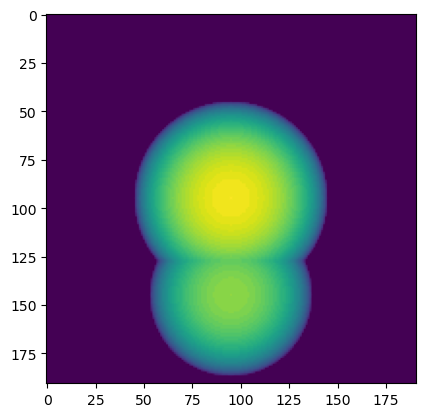

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_42_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


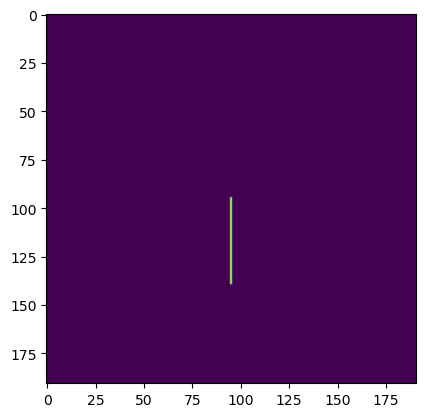

n dimensions: 3
n end pts: 2  |  n branch pts: 0


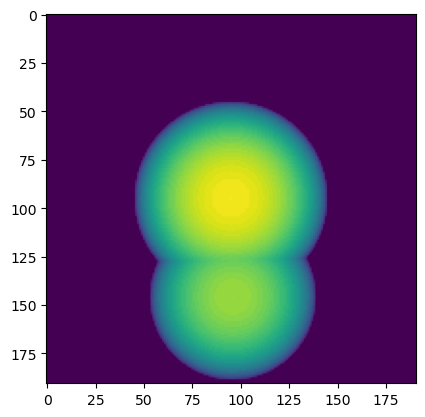

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_43_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


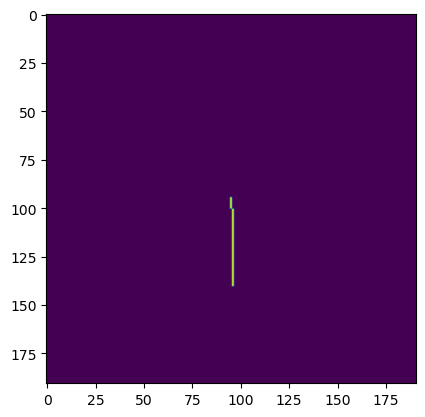

n dimensions: 3
n end pts: 2  |  n branch pts: 0


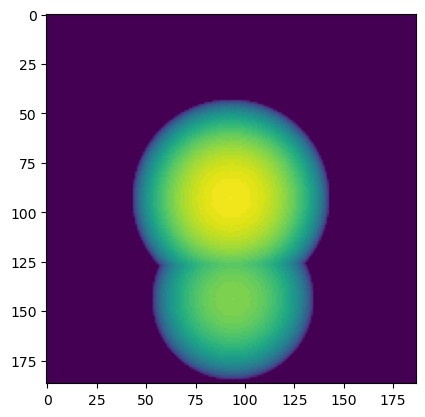

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_41_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


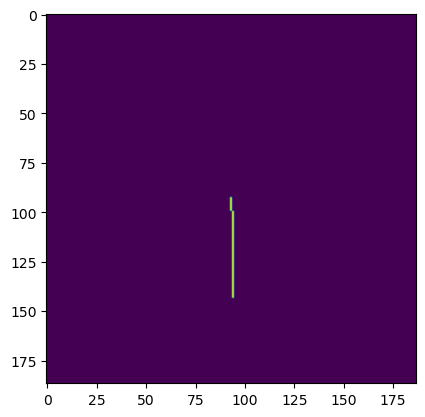

n dimensions: 3
n end pts: 2  |  n branch pts: 0


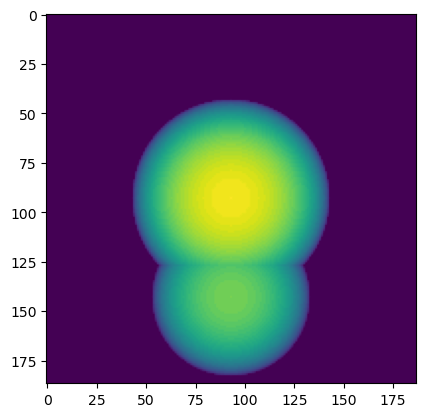

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_40_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


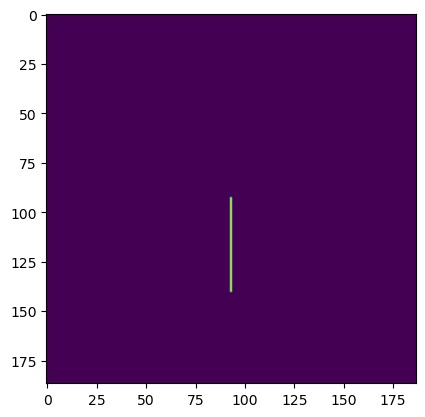

n dimensions: 3
n end pts: 2  |  n branch pts: 0


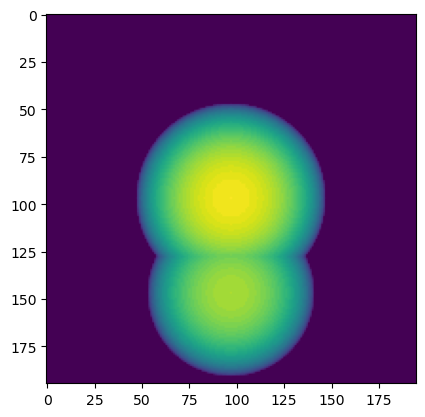

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_44_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


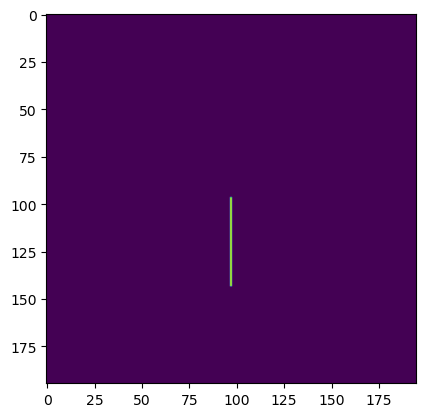

n dimensions: 3
n end pts: 2  |  n branch pts: 0


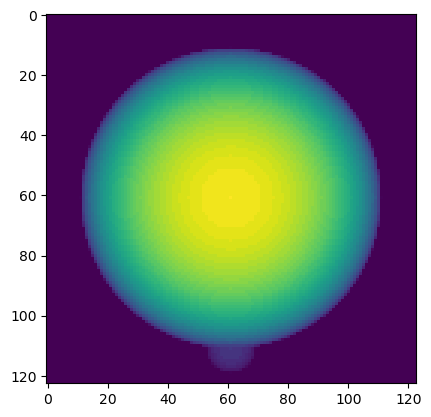

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_8_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


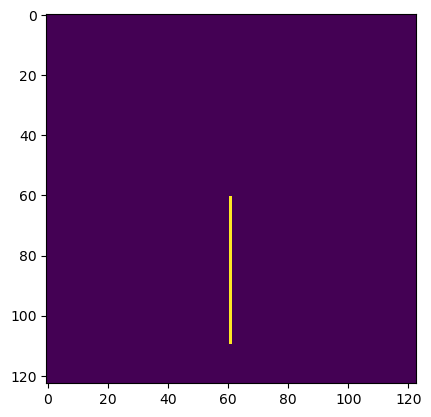

n dimensions: 3
n end pts: 2  |  n branch pts: 0


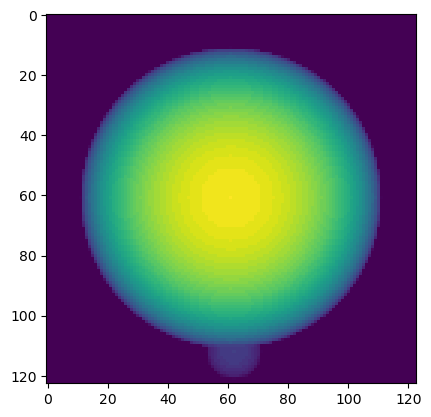

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_9_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


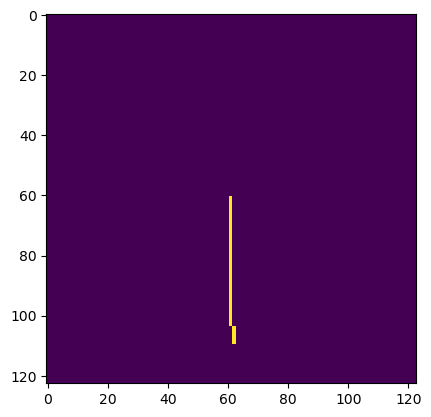

n dimensions: 3
n end pts: 2  |  n branch pts: 0


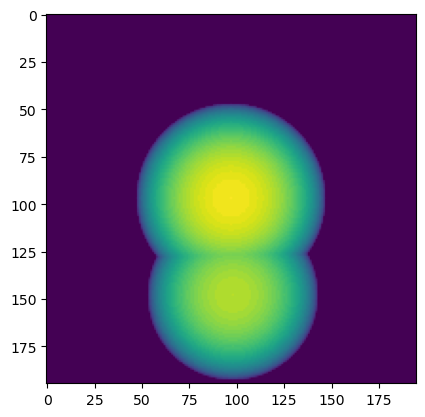

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_45_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


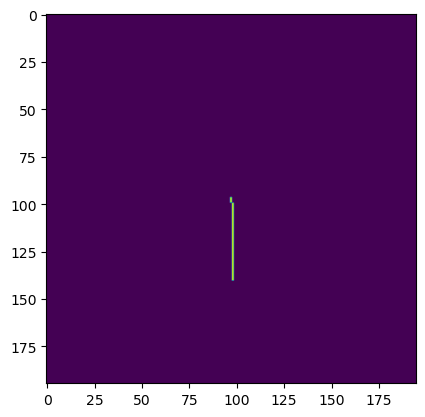

n dimensions: 3
n end pts: 2  |  n branch pts: 0


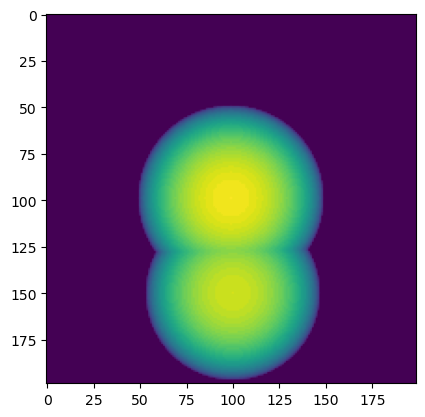

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_47_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


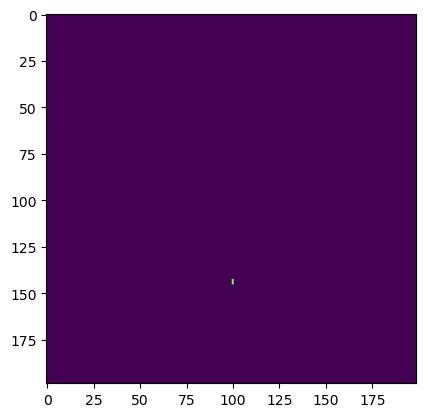

n dimensions: 3
n end pts: 2  |  n branch pts: 0


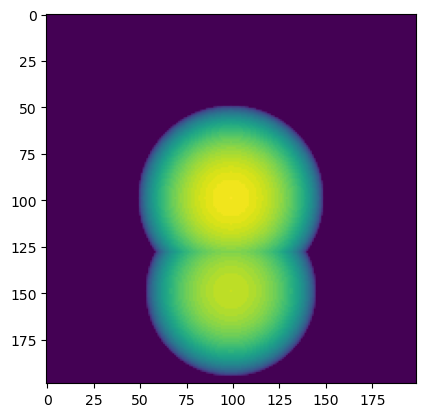

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_46_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


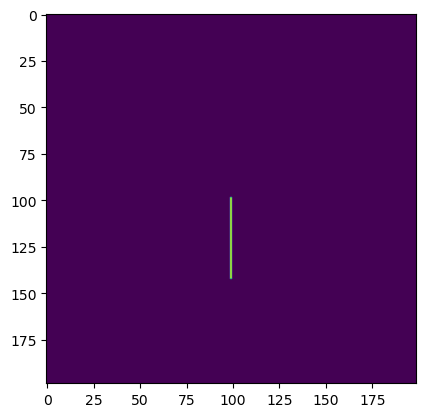

n dimensions: 3
n end pts: 2  |  n branch pts: 0


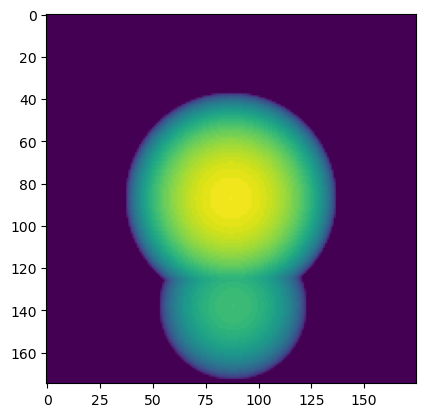

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_35_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


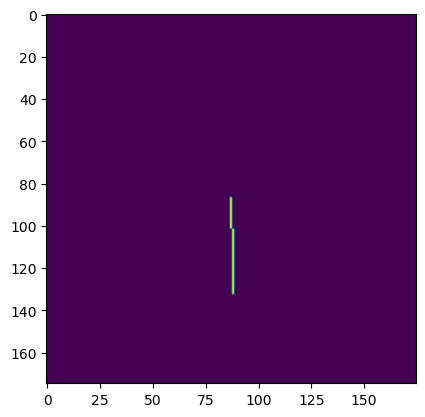

n dimensions: 3
n end pts: 2  |  n branch pts: 0


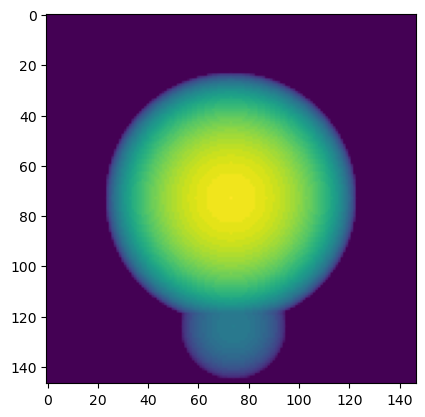

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_21_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


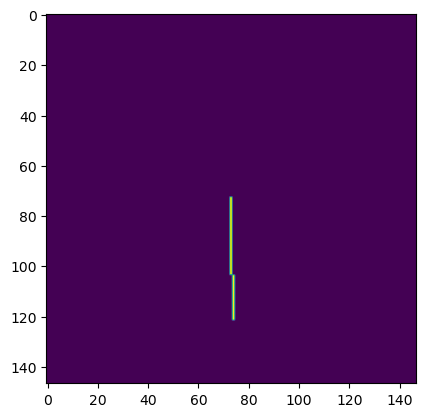

n dimensions: 3
n end pts: 2  |  n branch pts: 0


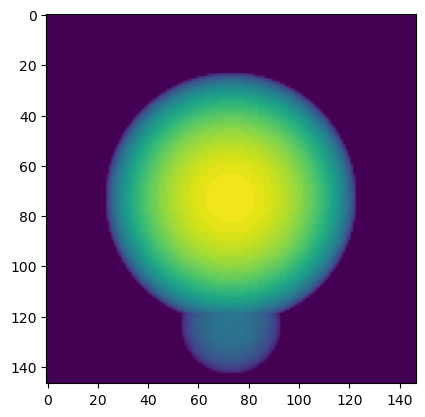

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_20_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


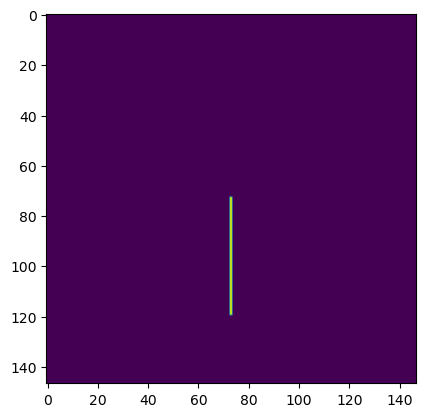

n dimensions: 3
n end pts: 2  |  n branch pts: 0


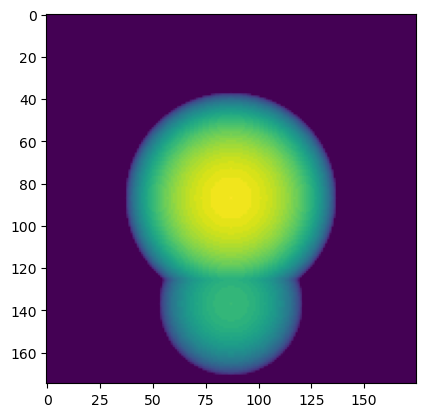

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_34_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


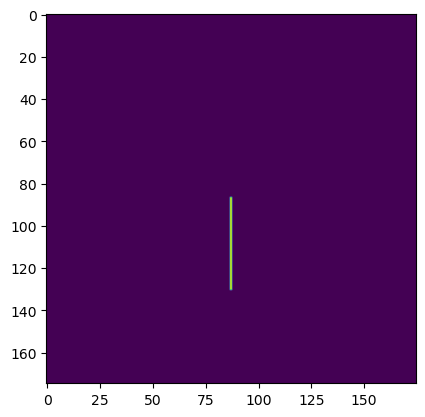

n dimensions: 3
n end pts: 2  |  n branch pts: 0


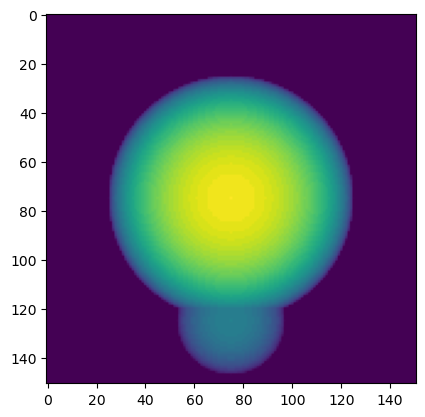

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_22_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


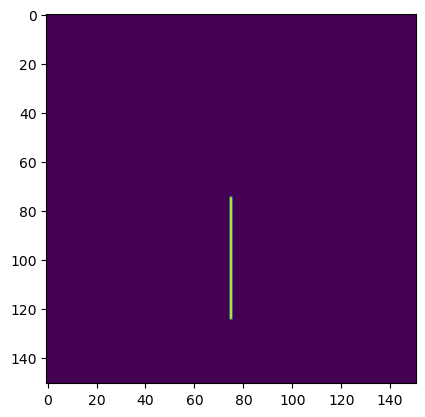

n dimensions: 3
n end pts: 2  |  n branch pts: 0


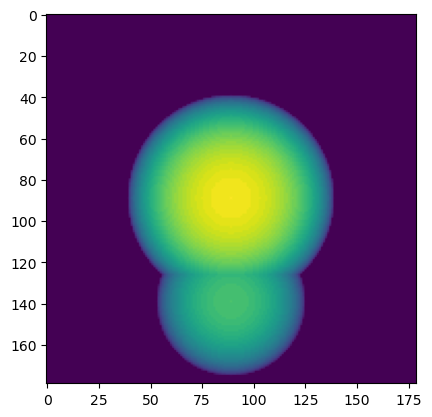

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_36_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


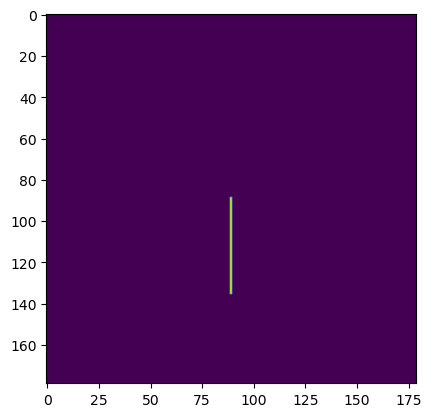

n dimensions: 3
n end pts: 2  |  n branch pts: 0


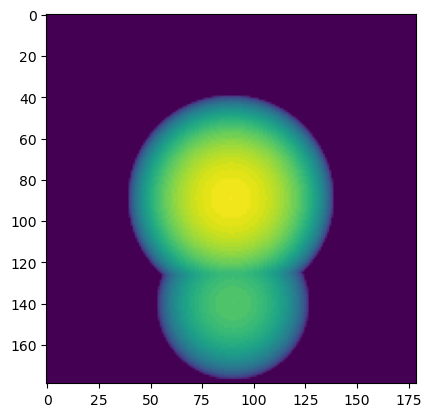

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_37_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


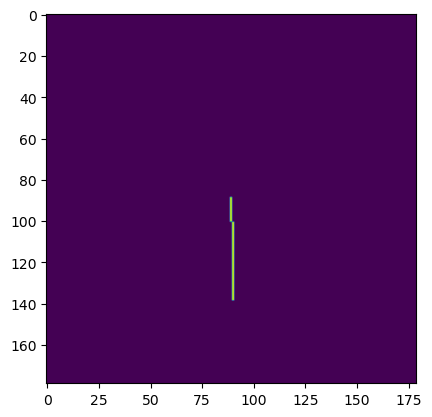

n dimensions: 3
n end pts: 2  |  n branch pts: 0


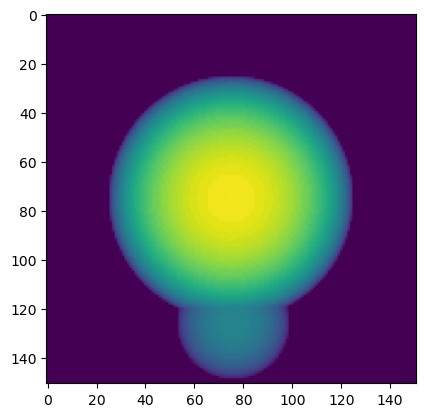

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_23_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


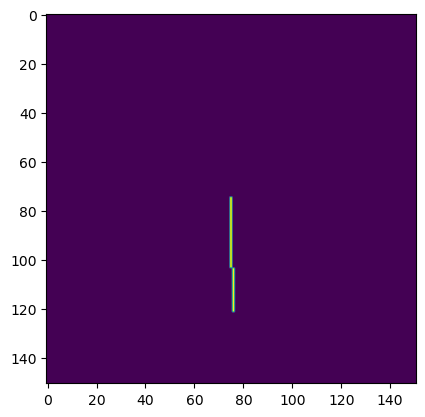

n dimensions: 3
n end pts: 2  |  n branch pts: 0


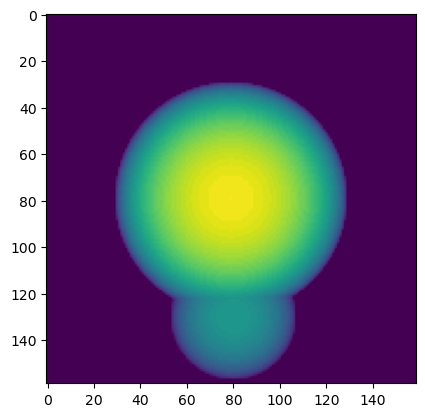

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_27_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


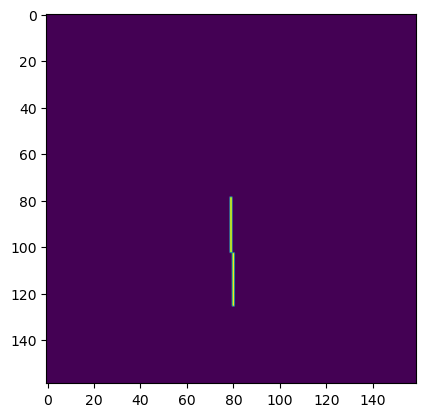

n dimensions: 3
n end pts: 2  |  n branch pts: 0


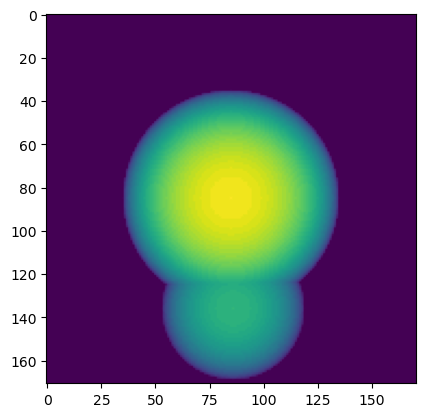

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_33_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


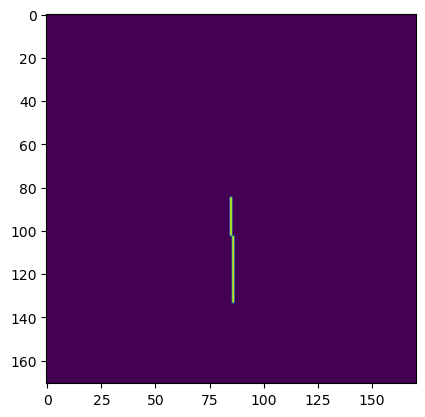

n dimensions: 3
n end pts: 2  |  n branch pts: 0


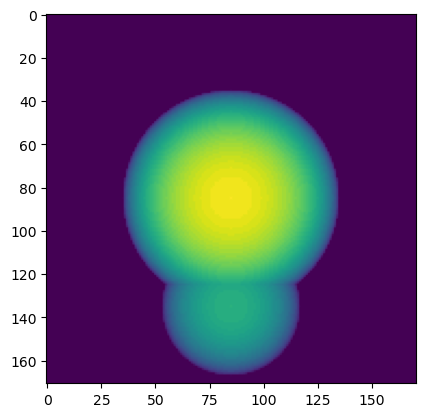

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_32_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


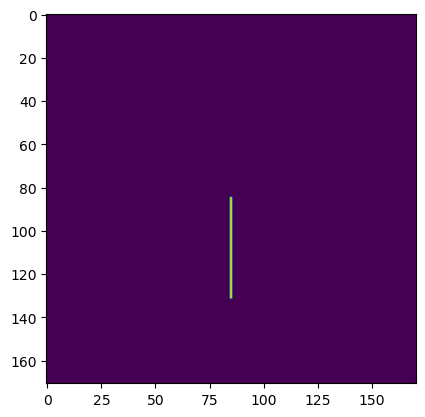

n dimensions: 3
n end pts: 2  |  n branch pts: 0


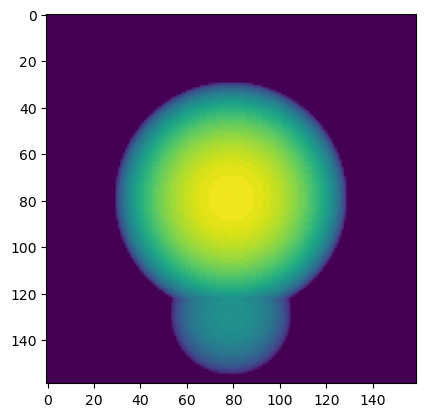

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_26_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


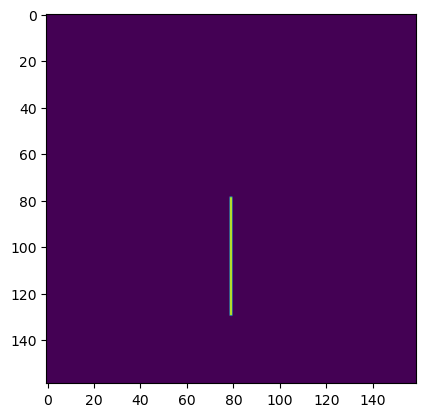

n dimensions: 3
n end pts: 2  |  n branch pts: 0


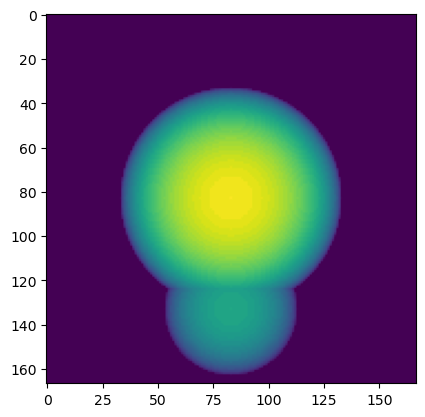

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_30_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


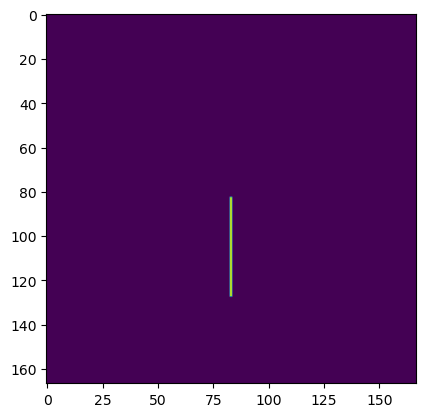

n dimensions: 3
n end pts: 2  |  n branch pts: 0


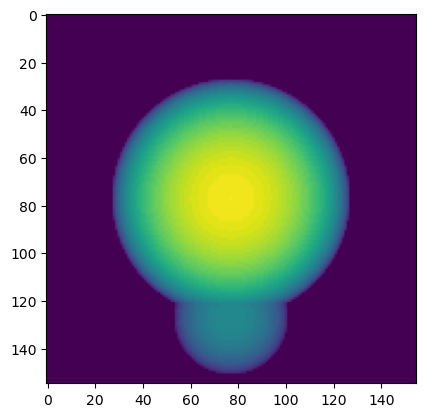

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_24_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


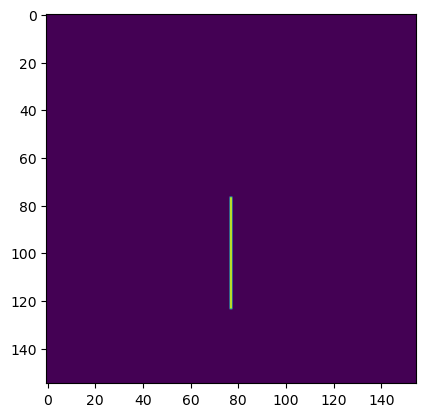

n dimensions: 3
n end pts: 2  |  n branch pts: 0


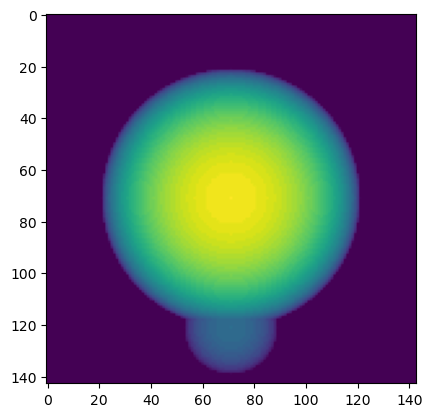

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_18_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


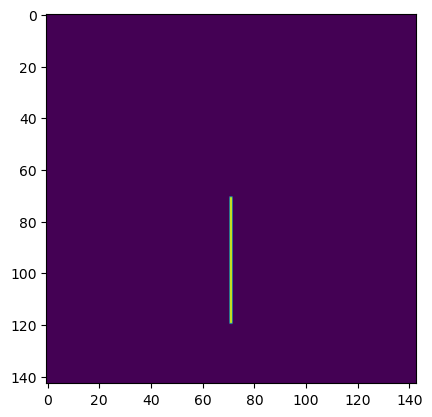

n dimensions: 3
n end pts: 2  |  n branch pts: 0


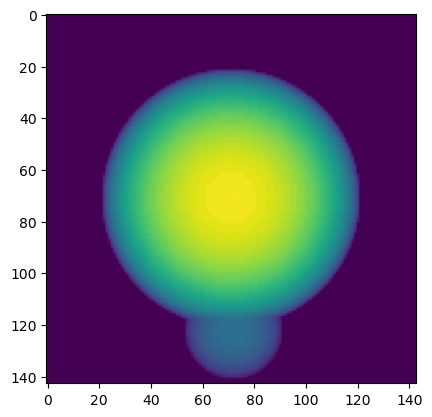

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_19_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


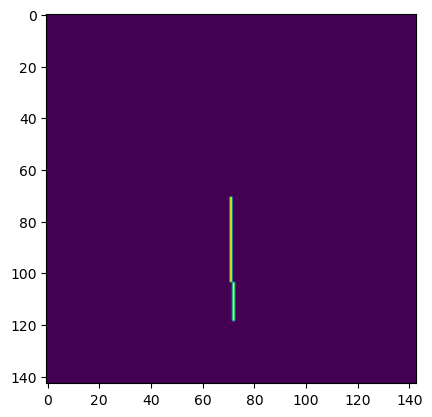

n dimensions: 3
n end pts: 2  |  n branch pts: 0


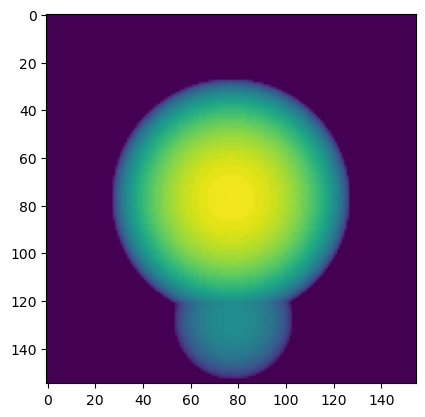

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_25_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


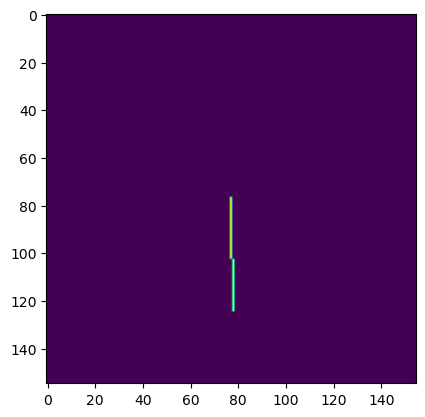

n dimensions: 3
n end pts: 2  |  n branch pts: 0


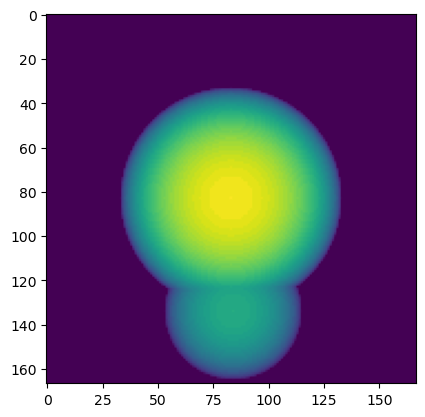

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_31_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


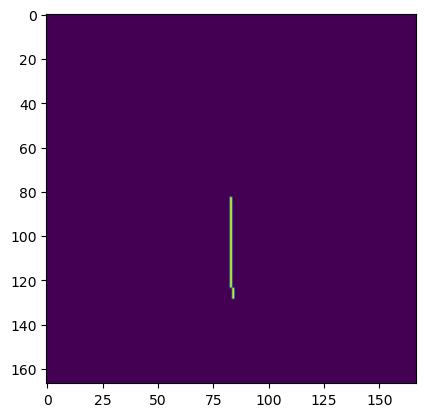

n dimensions: 3
n end pts: 2  |  n branch pts: 0


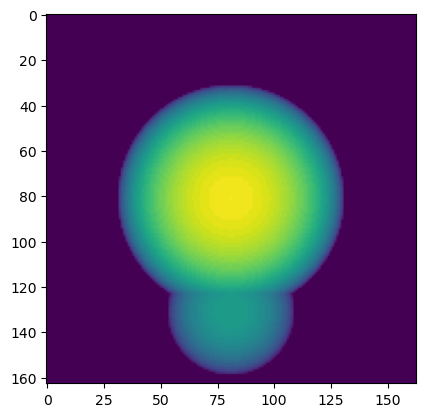

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_28_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


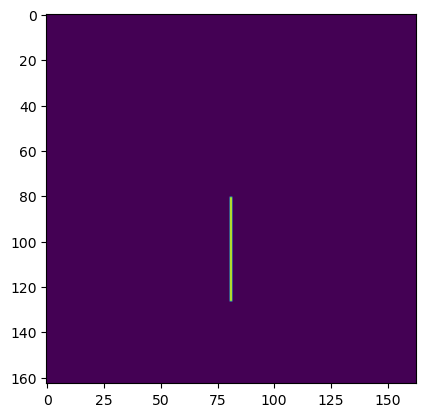

n dimensions: 3
n end pts: 2  |  n branch pts: 0


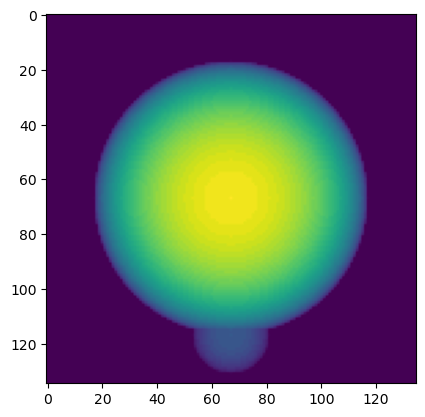

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_14_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


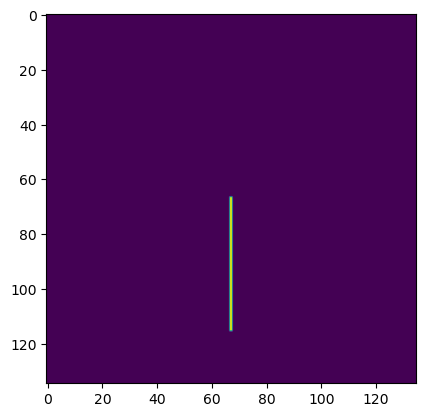

n dimensions: 3
n end pts: 2  |  n branch pts: 0


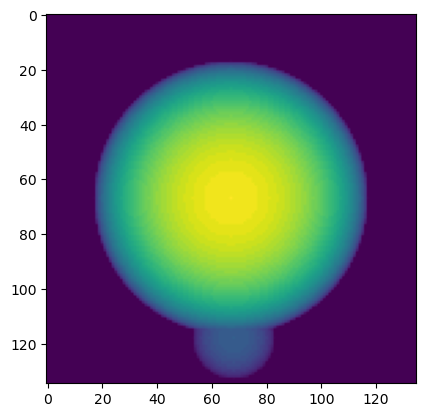

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_15_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


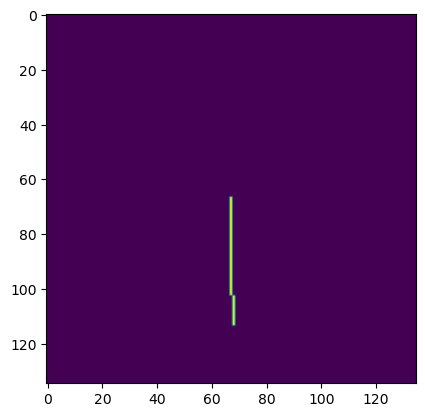

n dimensions: 3
n end pts: 2  |  n branch pts: 0


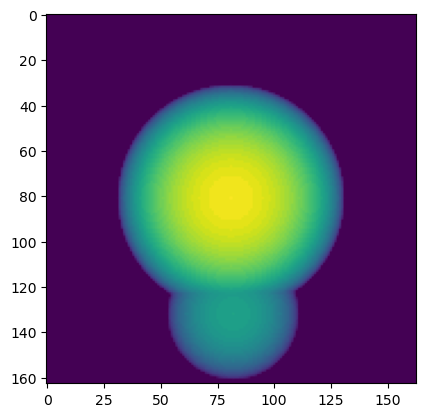

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_29_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


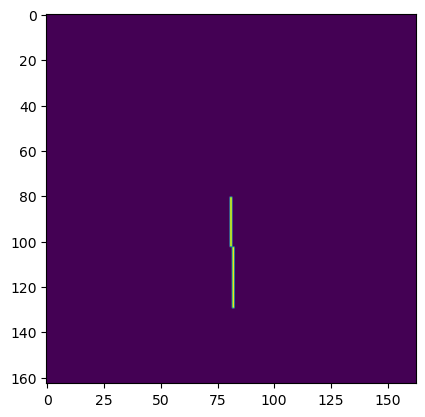

n dimensions: 3
n end pts: 2  |  n branch pts: 0


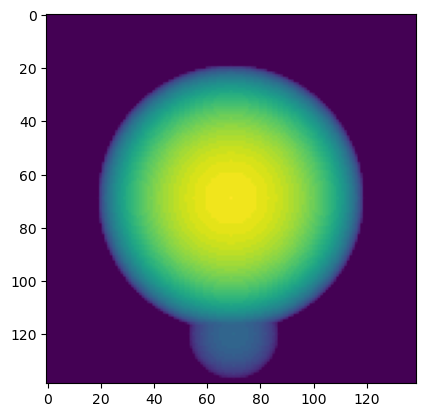

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_17_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


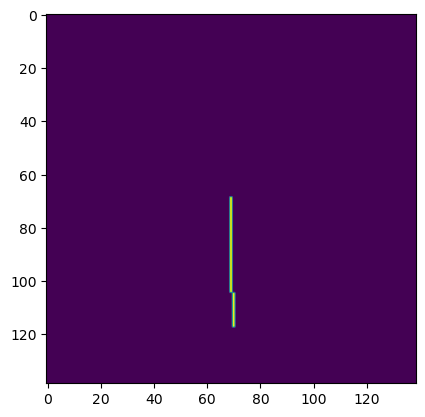

n dimensions: 3
n end pts: 2  |  n branch pts: 0


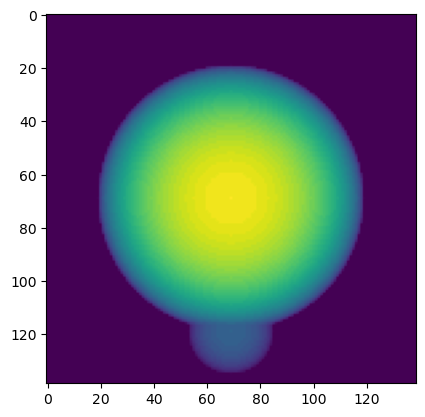

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_16_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


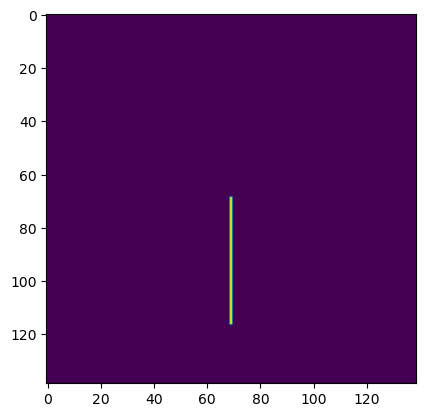

n dimensions: 3
n end pts: 2  |  n branch pts: 0


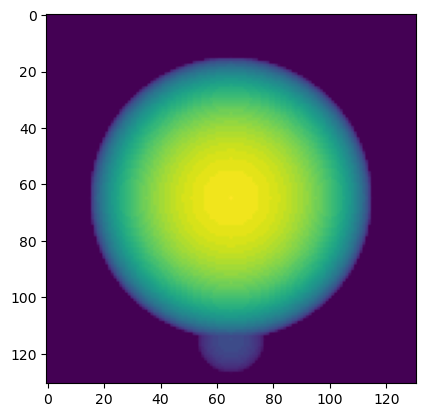

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_12_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


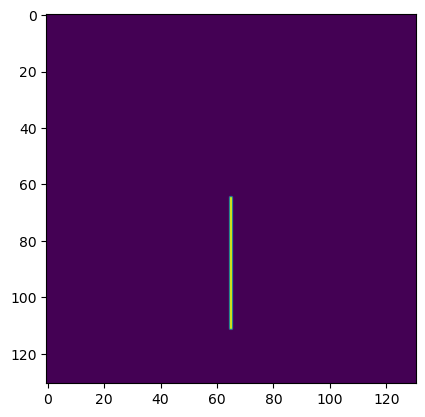

n dimensions: 3
n end pts: 2  |  n branch pts: 0


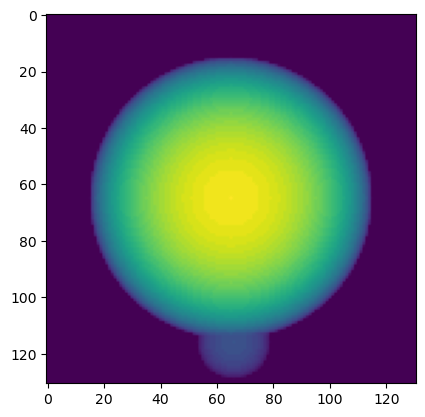

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_13_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


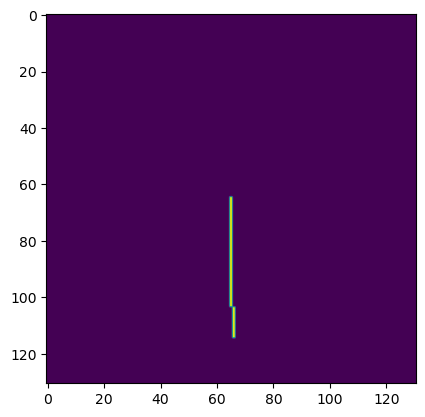

n dimensions: 3
n end pts: 2  |  n branch pts: 0


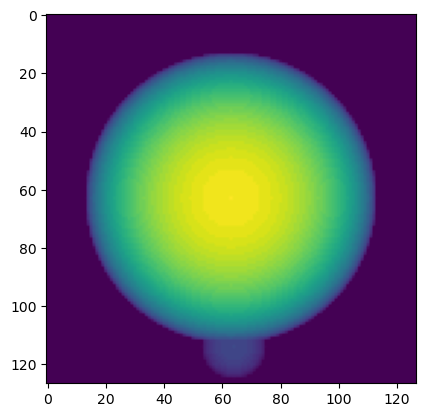

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_11_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


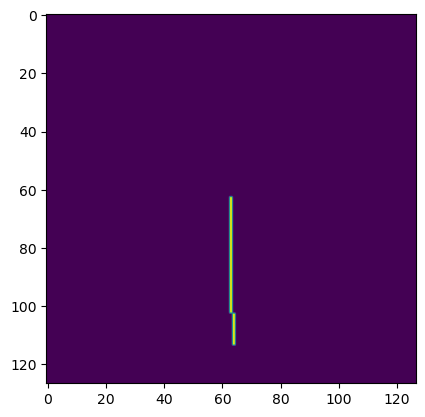

n dimensions: 3
n end pts: 2  |  n branch pts: 0


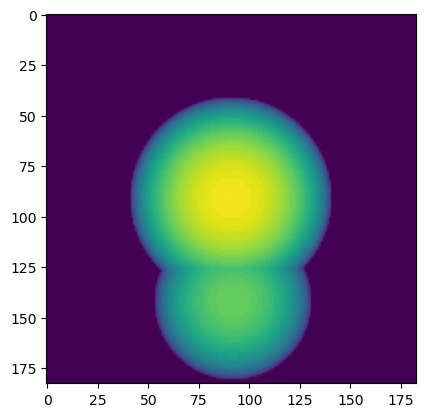

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_39_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


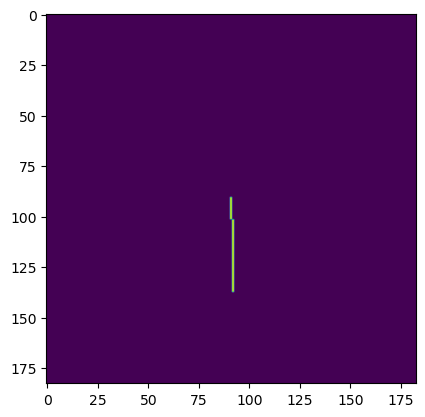

n dimensions: 3
n end pts: 2  |  n branch pts: 0


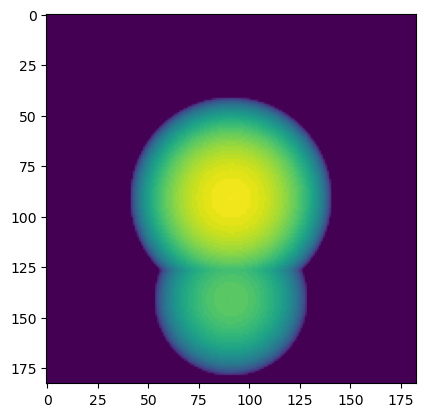

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_38_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


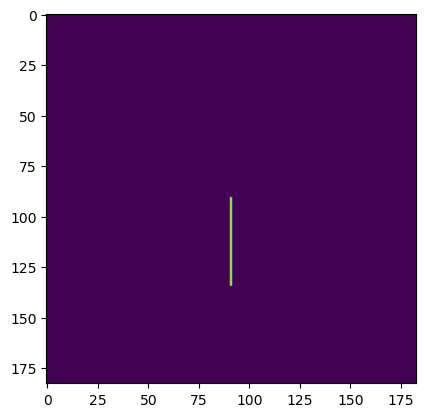

n dimensions: 3
n end pts: 2  |  n branch pts: 0


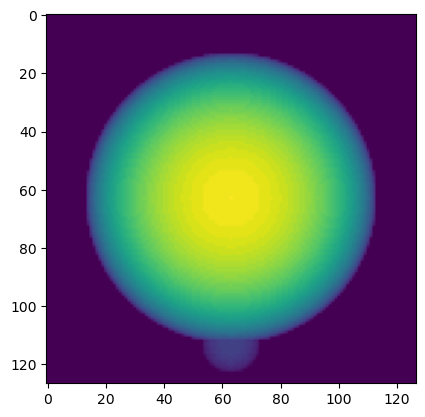

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_10_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


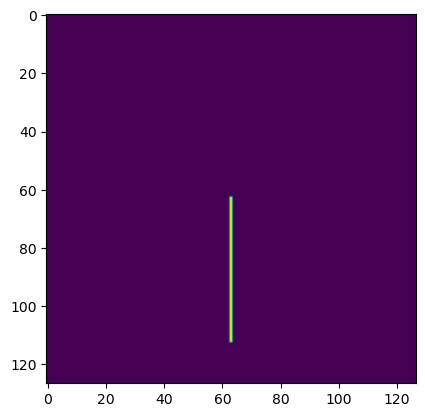

n dimensions: 3
n end pts: 2  |  n branch pts: 0


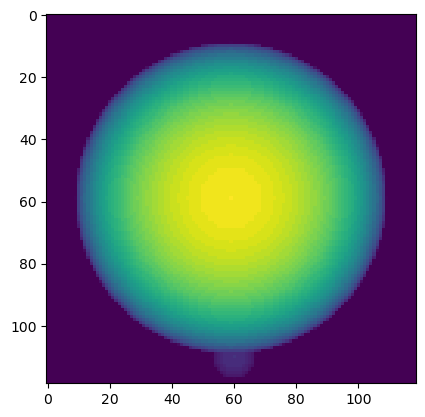

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_7_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


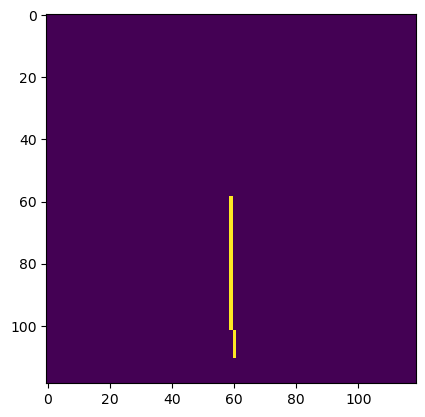

n dimensions: 3
n end pts: 2  |  n branch pts: 0


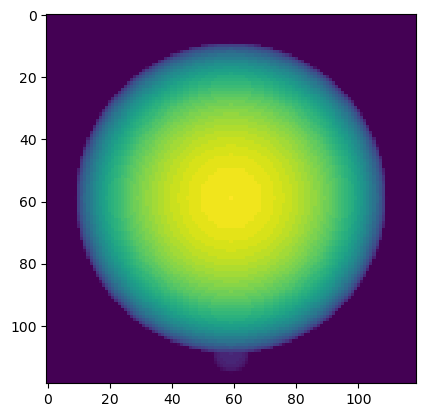

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_6_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


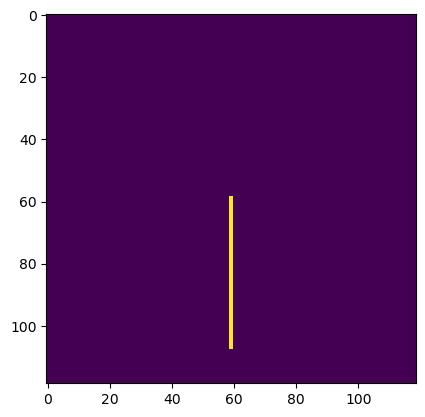

n dimensions: 3
n end pts: 2  |  n branch pts: 0


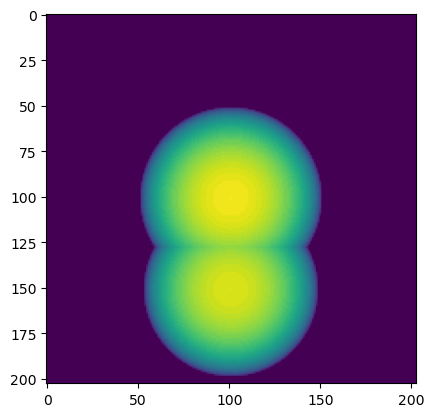

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_48_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


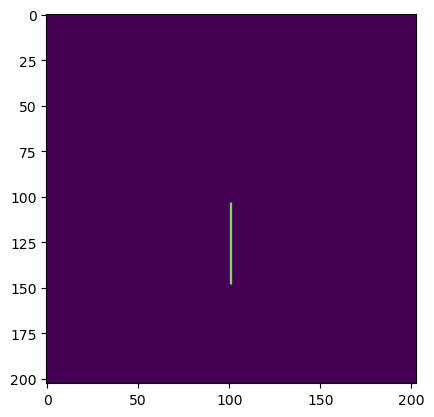

n dimensions: 3
n end pts: 2  |  n branch pts: 0


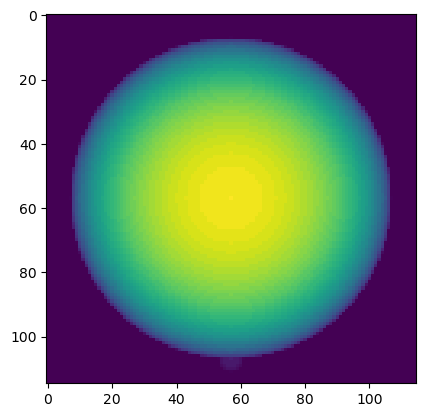

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_4_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


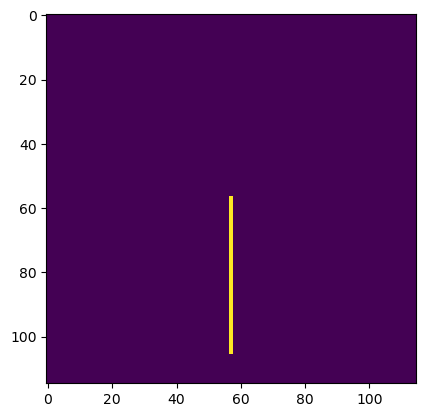

n dimensions: 3
n end pts: 2  |  n branch pts: 0


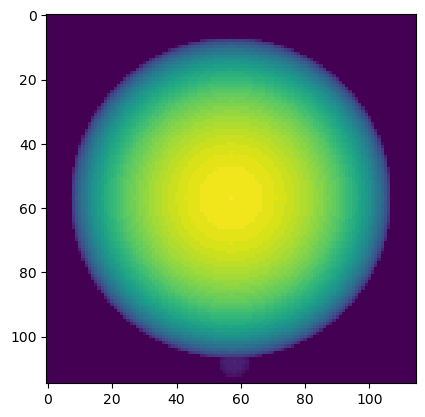

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_5_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


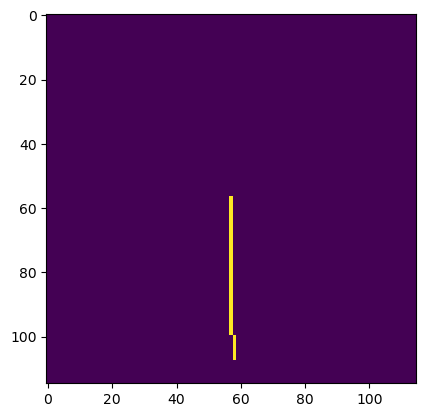

n dimensions: 3
n end pts: 2  |  n branch pts: 0


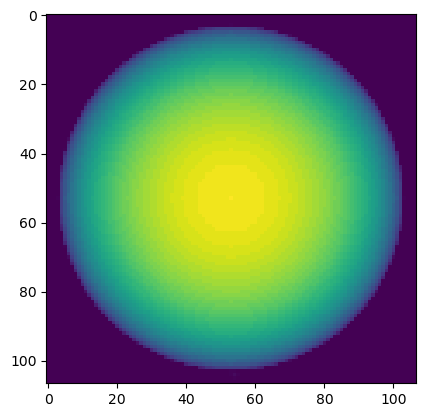

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_1_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


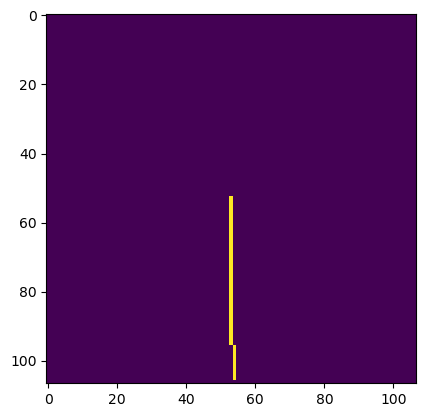

n dimensions: 3
n end pts: 2  |  n branch pts: 0


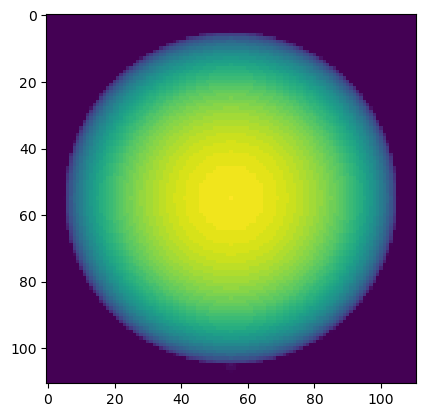

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_2_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


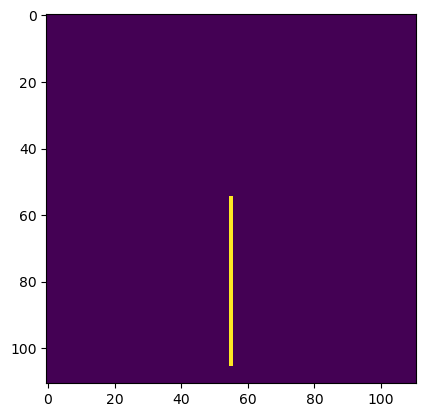

n dimensions: 3
n end pts: 2  |  n branch pts: 0


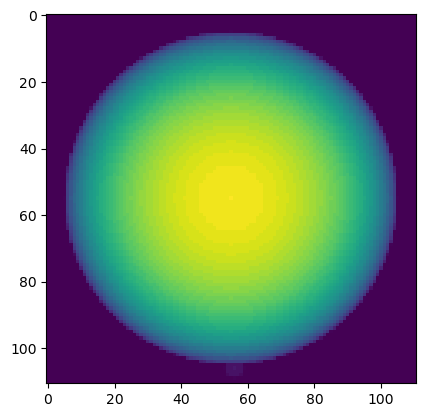

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/455891502.py:13: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_3_skel.tif is a low contrast image
  imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))


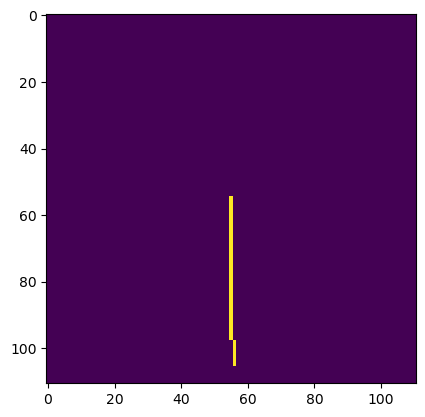

n dimensions: 3
n end pts: 2  |  n branch pts: 0


In [12]:
## generate skeletons & parse

n_samples = len(arrs)
skels = [0] * n_samples
parsings = [0] * n_samples

counter = 0
for i in arrs:
    plt.imshow(i.sum(axis = 0))
    plt.show()
    i_skel = skeletonize(i)
    skels[counter] = i_skel
    imsave(os.path.join(fpath, names[counter] + '_skel.tif'), i_skel.astype(np.uint8))
    plt.imshow(i_skel.sum(axis = 0))
    plt.show()
    i_parse = parse_skeleton_3d(i_skel, 0, 1, 2)
    parsings[counter] = i_parse
    np.save(os.path.join(fpath, names[counter] + '_parsed'), i_parse, allow_pickle=True)
    counter += 1

n_ep: 2 | n_bp: 0 | brnch_ls: (45,)


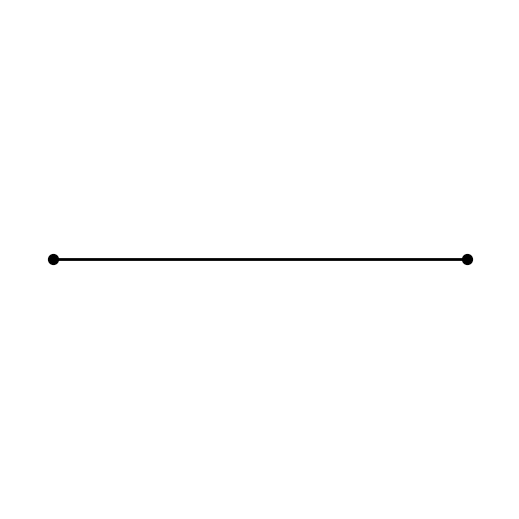

[0, 1]
45.0
0 0 -- 45.0


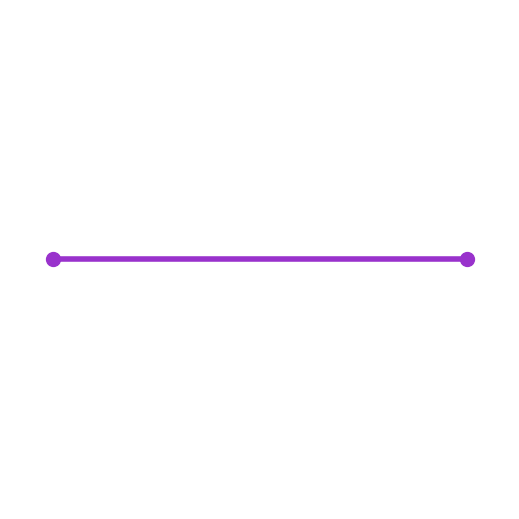

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_42_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


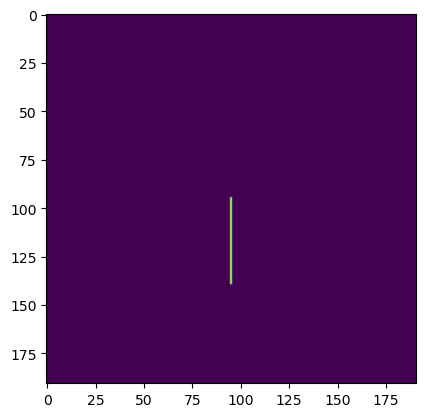

n_ep: 2 | n_bp: 0 | brnch_ls: (46,)


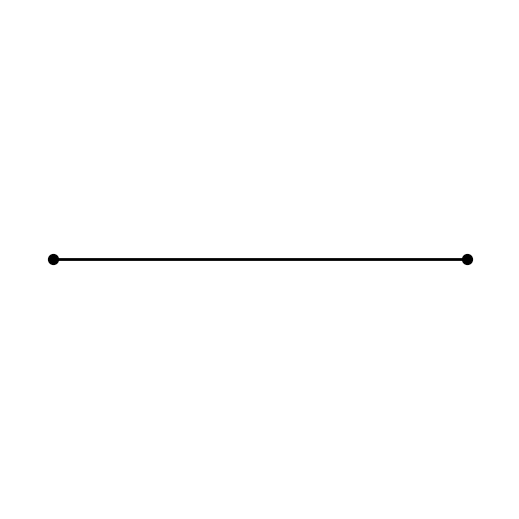

[0, 1]
46.0
0 0 -- 46.0


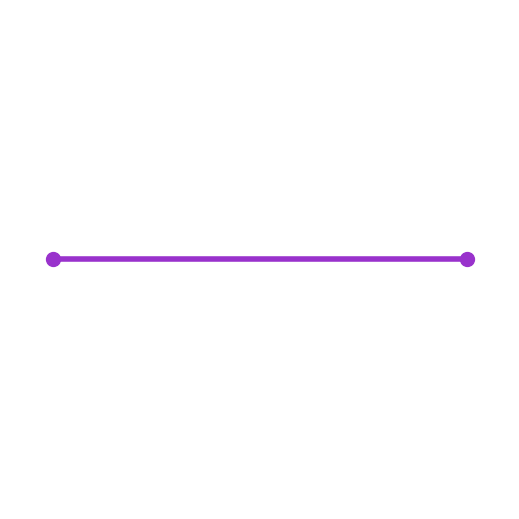

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_43_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


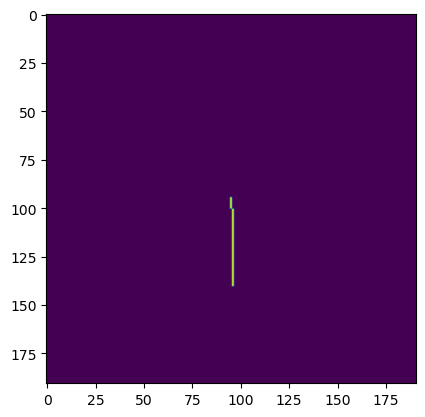

n_ep: 2 | n_bp: 0 | brnch_ls: (51,)


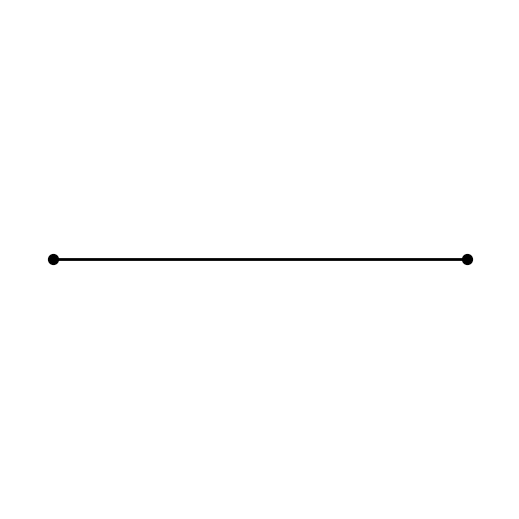

[0, 1]
51.0
0 0 -- 51.0


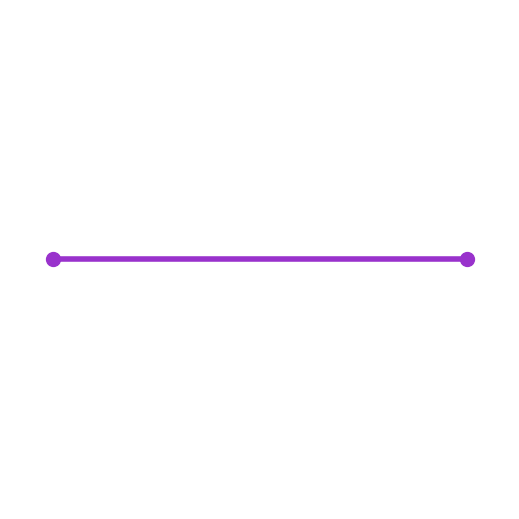

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_41_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


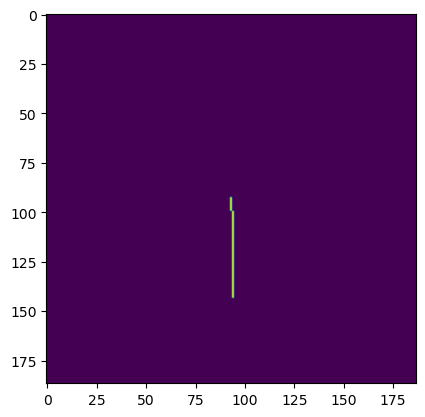

n_ep: 2 | n_bp: 0 | brnch_ls: (48,)


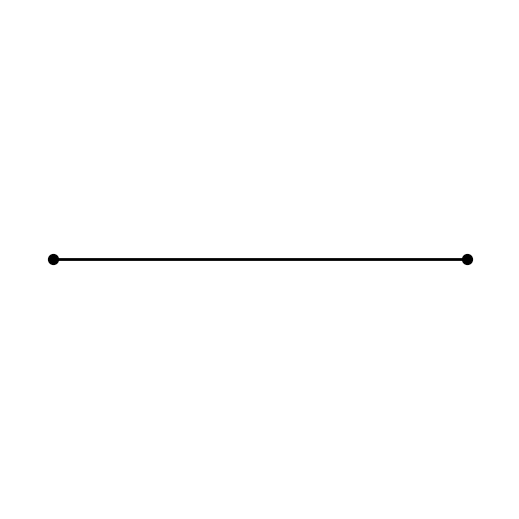

[0, 1]
48.0
0 0 -- 48.0


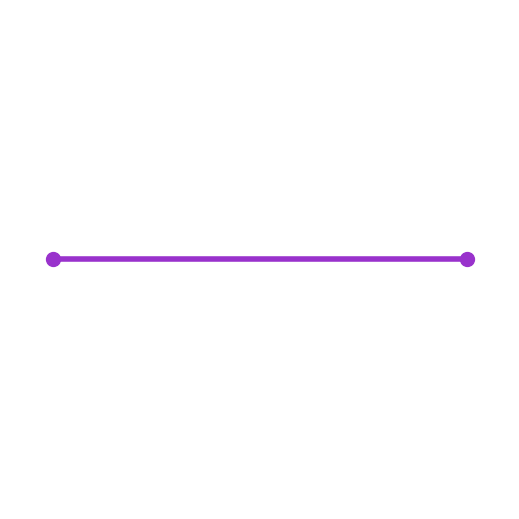

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_40_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


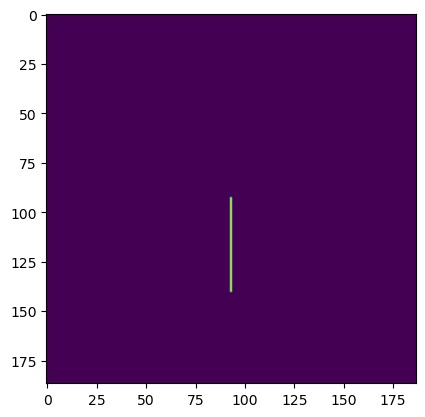

n_ep: 2 | n_bp: 0 | brnch_ls: (47,)


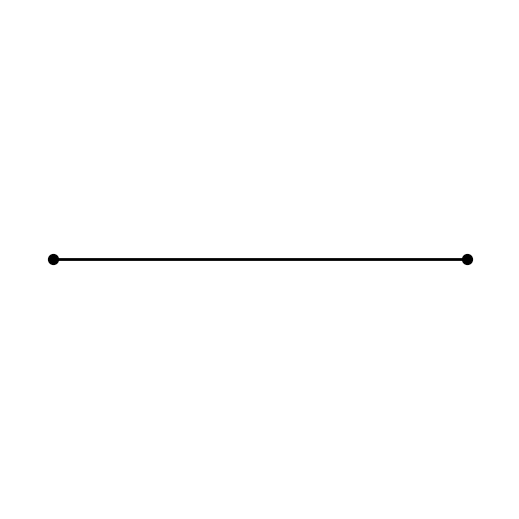

[0, 1]
47.0
0 0 -- 47.0


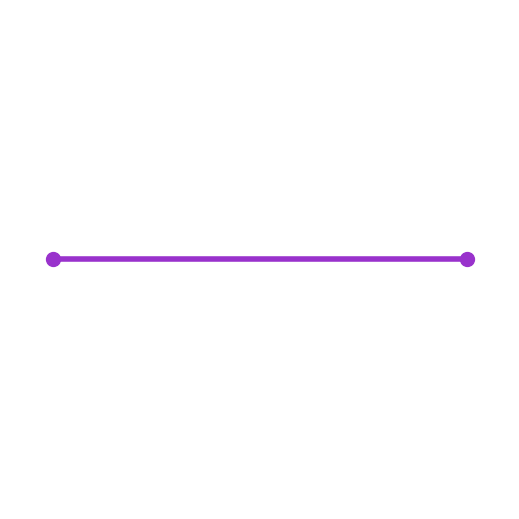

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_44_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


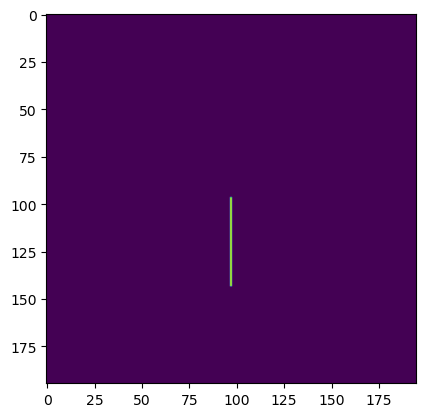

n_ep: 2 | n_bp: 0 | brnch_ls: (49,)


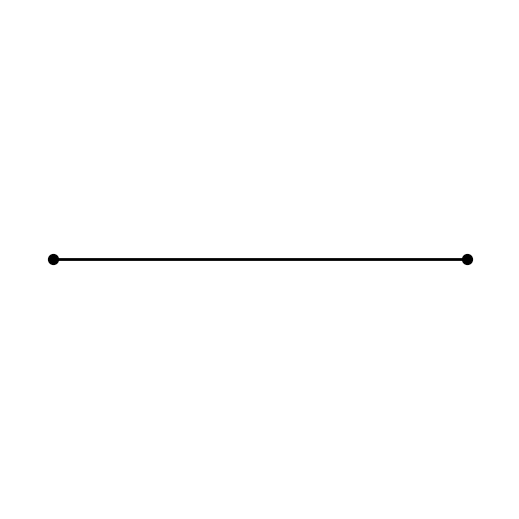

[0, 1]
49.0
0 0 -- 49.0


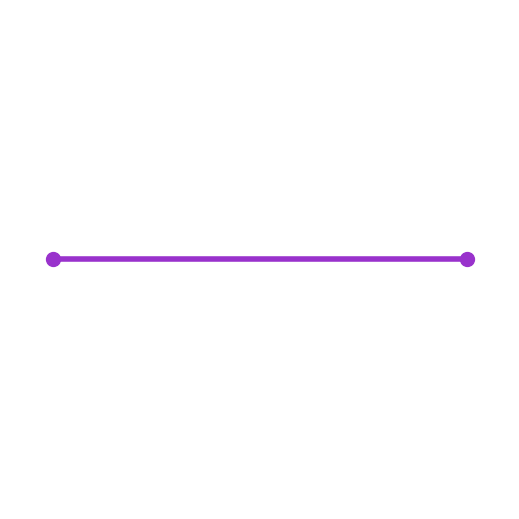

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_8_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


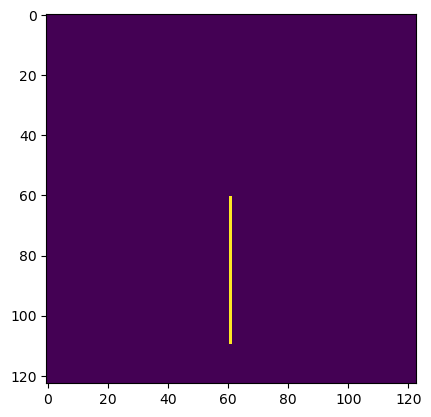

n_ep: 2 | n_bp: 0 | brnch_ls: (49,)


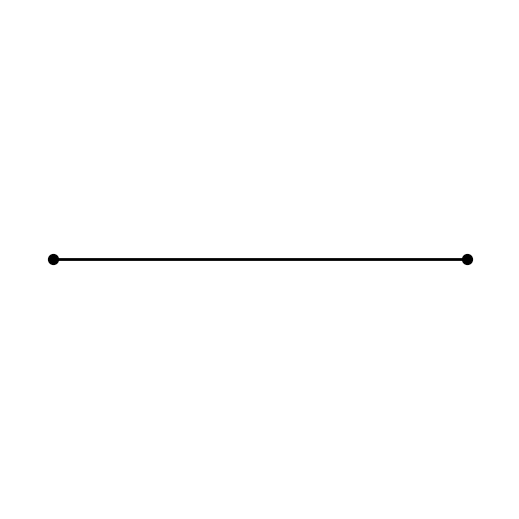

[0, 1]
49.0
0 0 -- 49.0


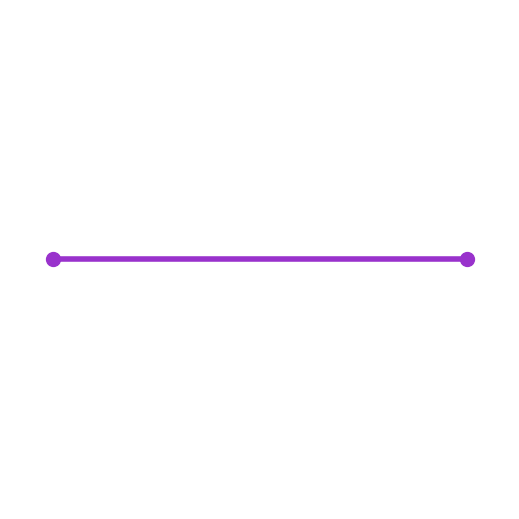

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_9_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


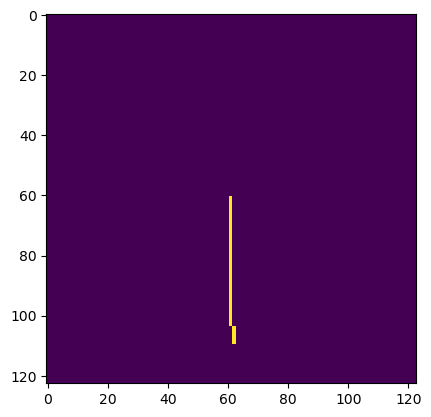

n_ep: 2 | n_bp: 0 | brnch_ls: (44,)


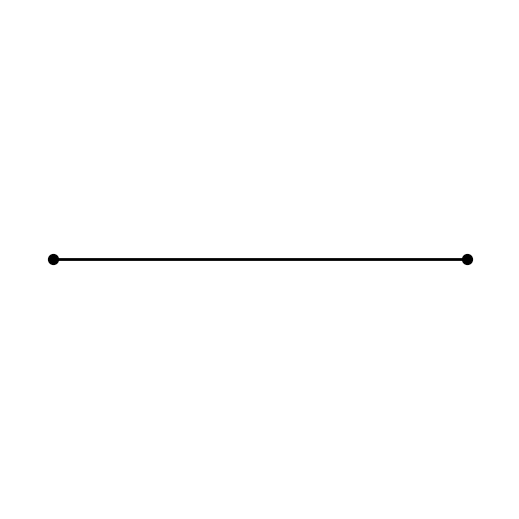

[0, 1]
44.0
0 0 -- 44.0


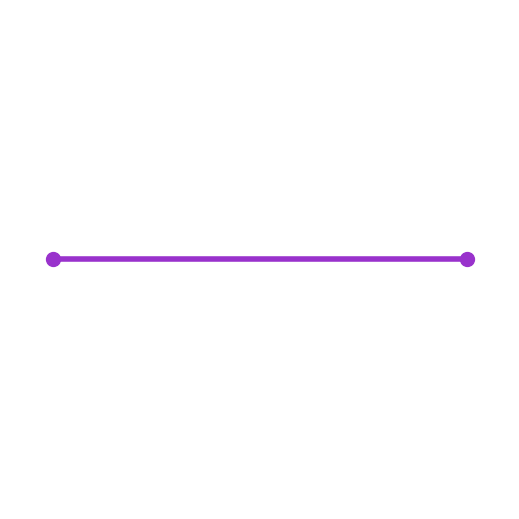

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_45_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


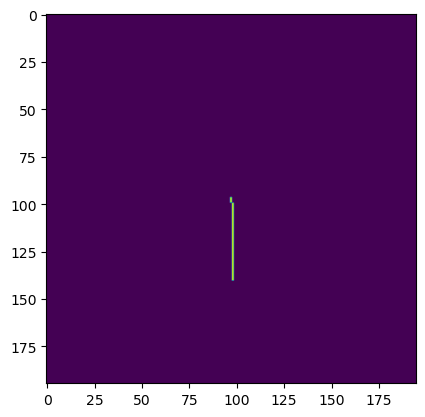

n_ep: 2 | n_bp: 0 | brnch_ls: (3,)


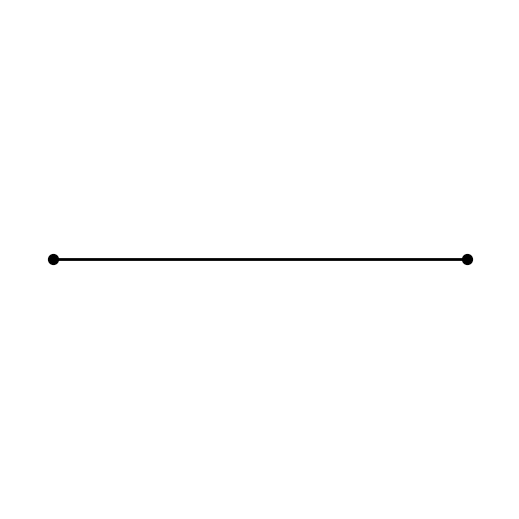

[0, 1]
3.0
0 0 -- 3.0


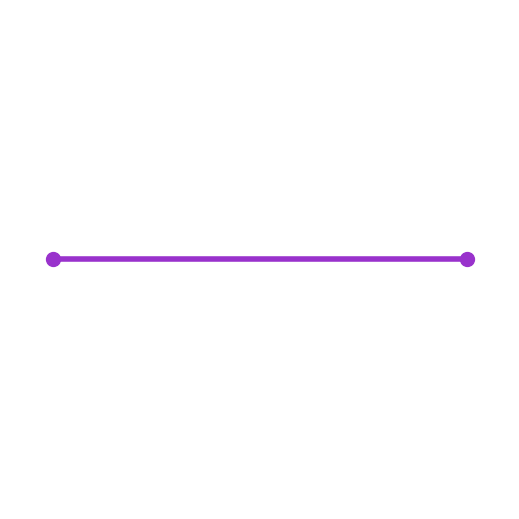

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_47_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


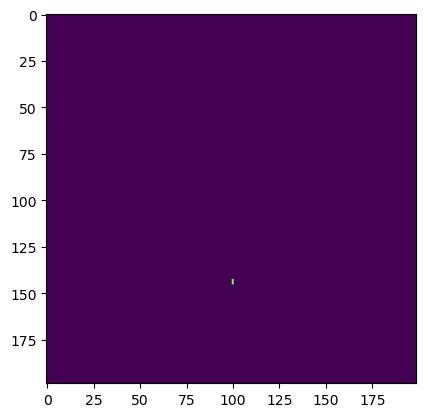

n_ep: 2 | n_bp: 0 | brnch_ls: (44,)


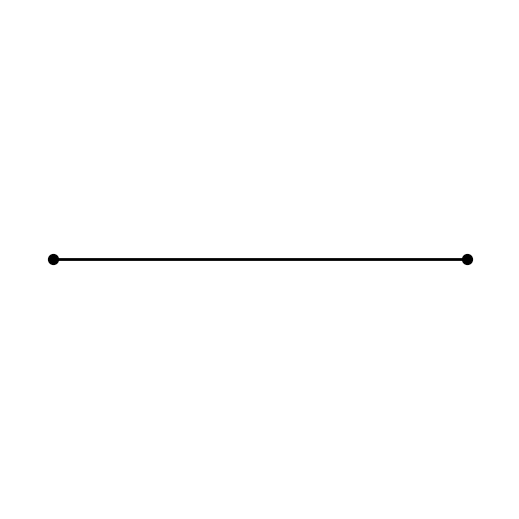

[0, 1]
44.0
0 0 -- 44.0


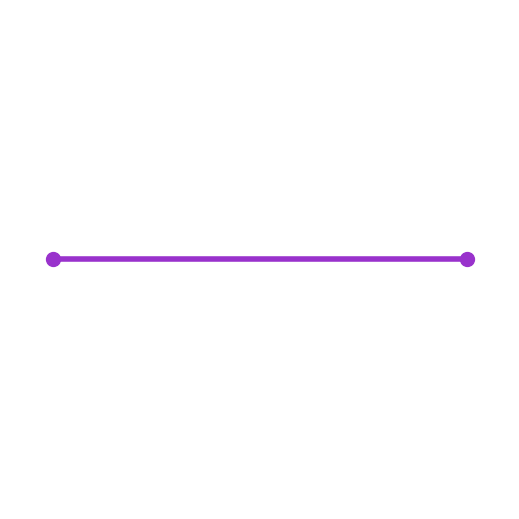

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_46_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


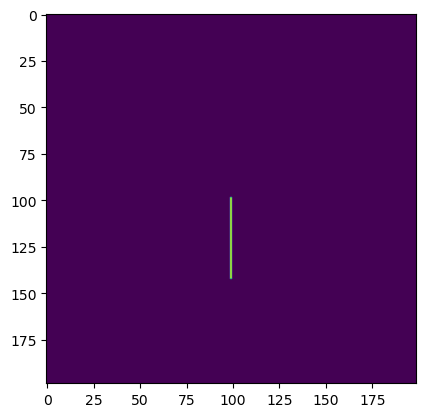

n_ep: 2 | n_bp: 0 | brnch_ls: (46,)


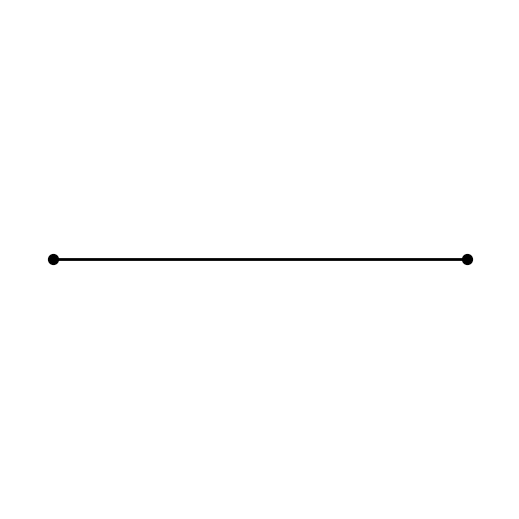

[0, 1]
46.0
0 0 -- 46.0


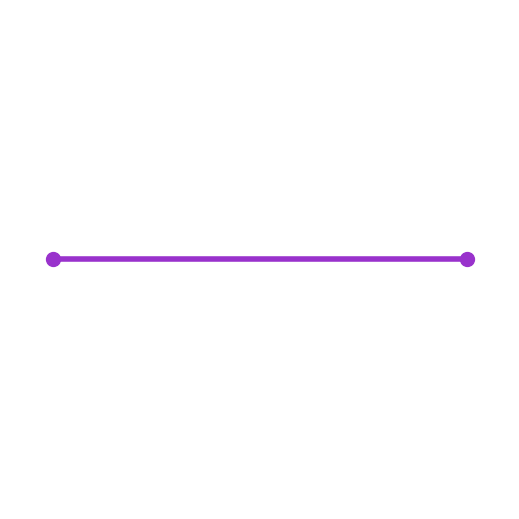

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_35_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


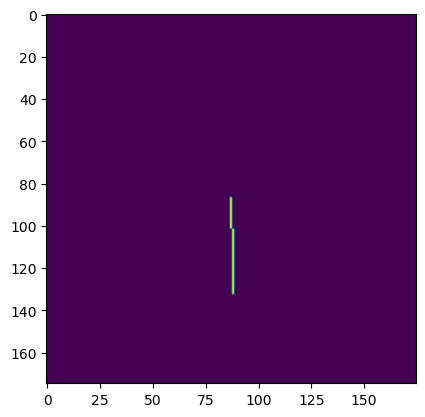

n_ep: 2 | n_bp: 0 | brnch_ls: (49,)


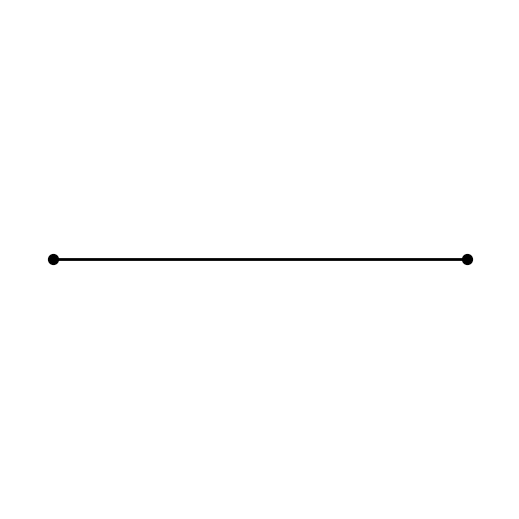

[0, 1]
49.0
0 0 -- 49.0


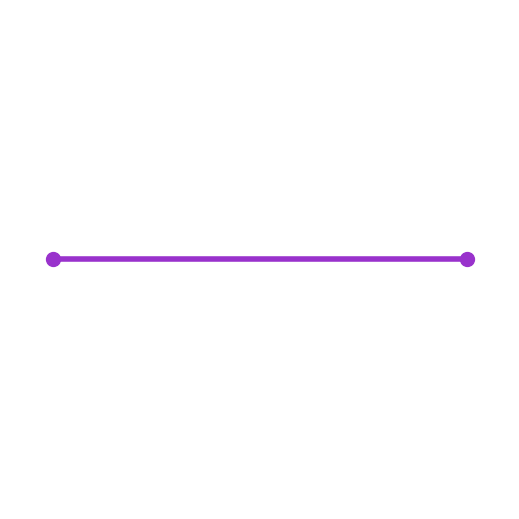

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_21_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


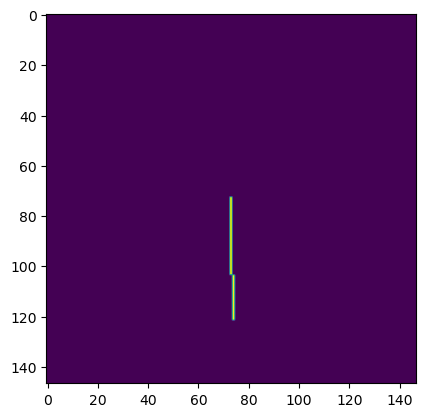

n_ep: 2 | n_bp: 0 | brnch_ls: (47,)


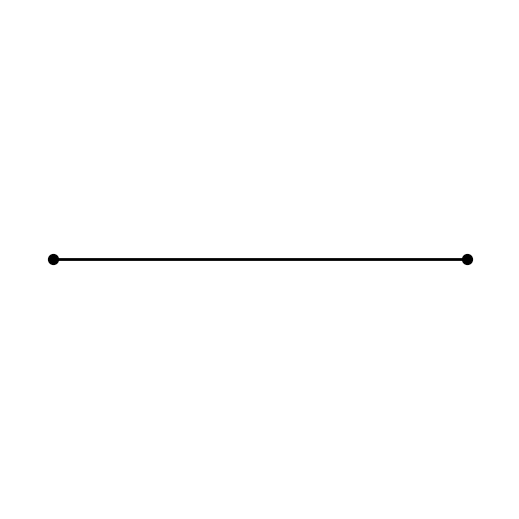

[0, 1]
47.0
0 0 -- 47.0


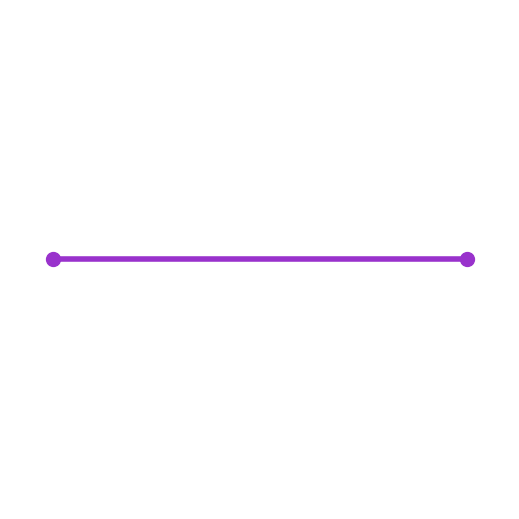

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_20_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


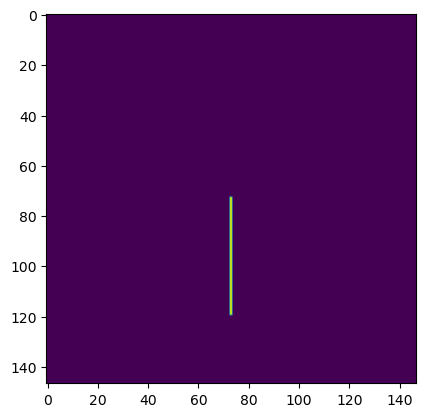

n_ep: 2 | n_bp: 0 | brnch_ls: (44,)


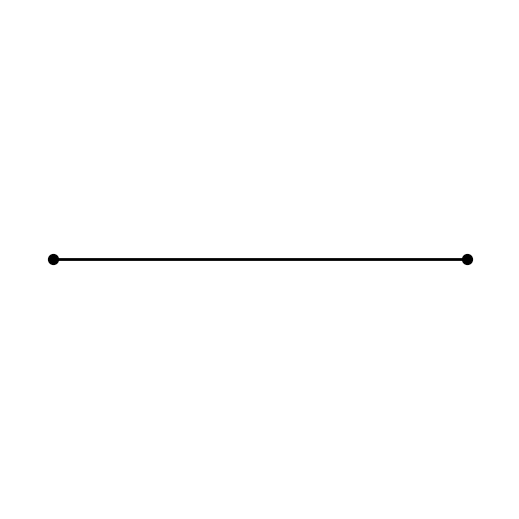

[0, 1]
44.0
0 0 -- 44.0


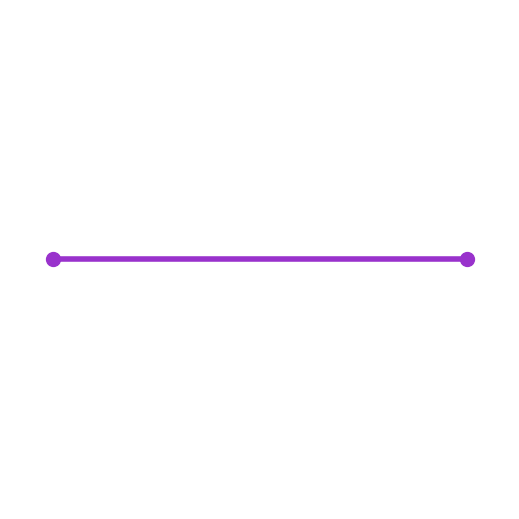

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_34_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


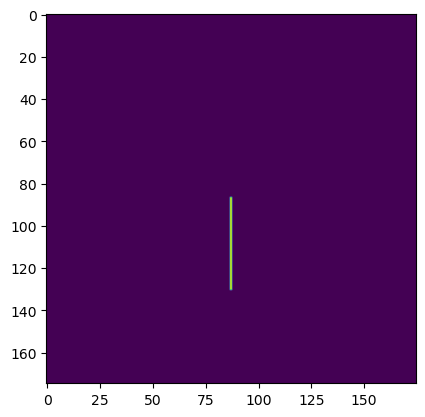

n_ep: 2 | n_bp: 0 | brnch_ls: (50,)


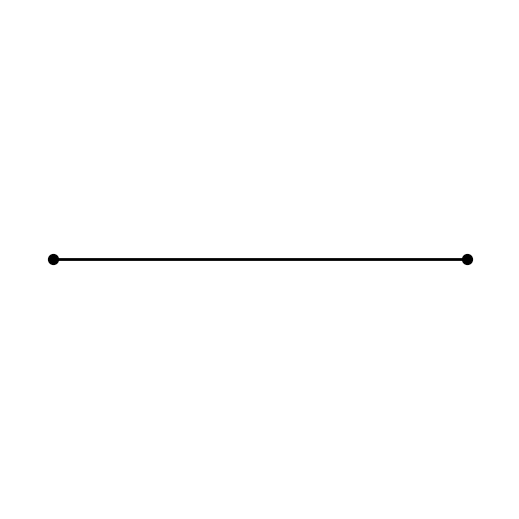

[0, 1]
50.0
0 0 -- 50.0


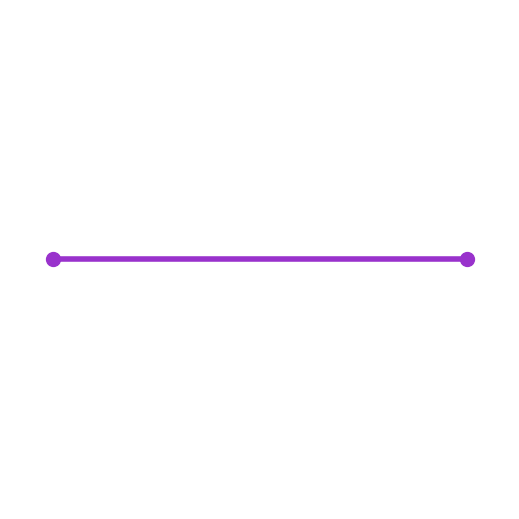

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_22_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


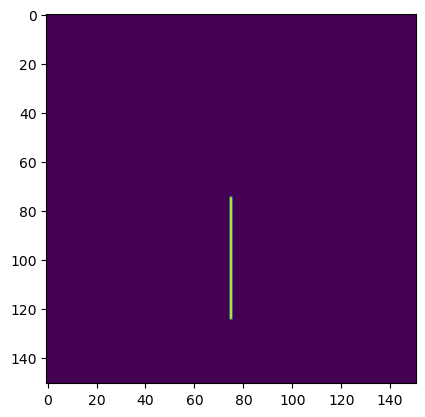

n_ep: 2 | n_bp: 0 | brnch_ls: (47,)


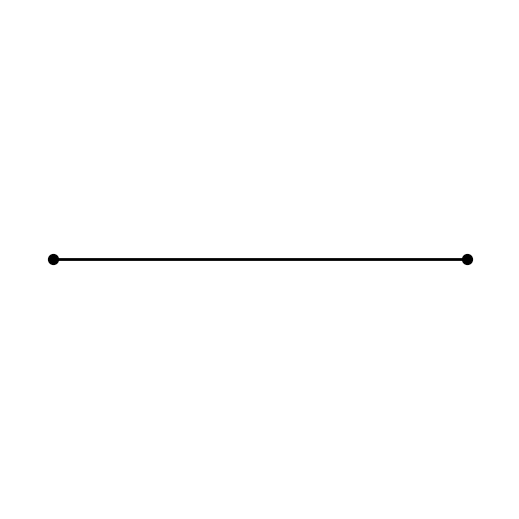

[0, 1]
47.0
0 0 -- 47.0


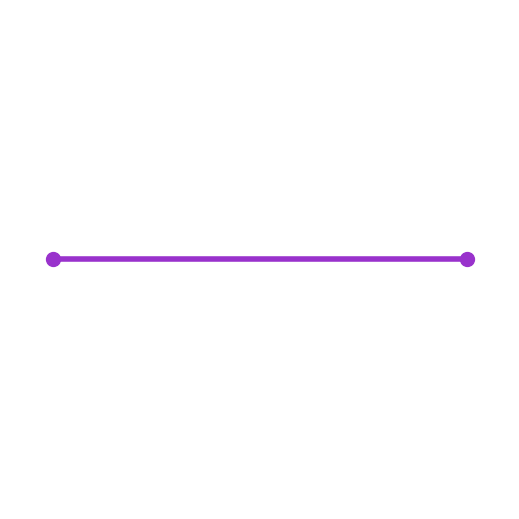

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_36_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


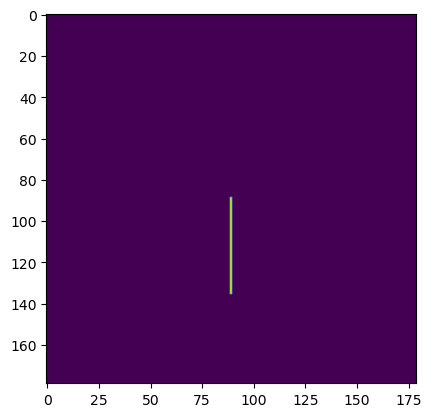

n_ep: 2 | n_bp: 0 | brnch_ls: (50,)


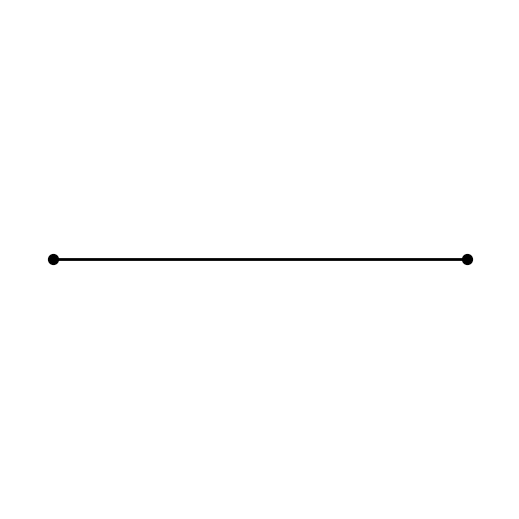

[0, 1]
50.0
0 0 -- 50.0


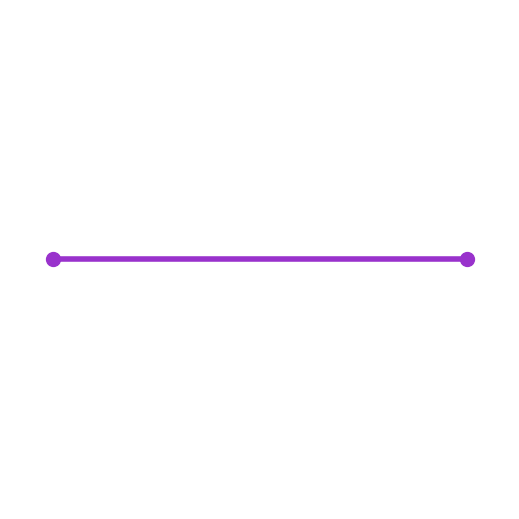

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_37_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


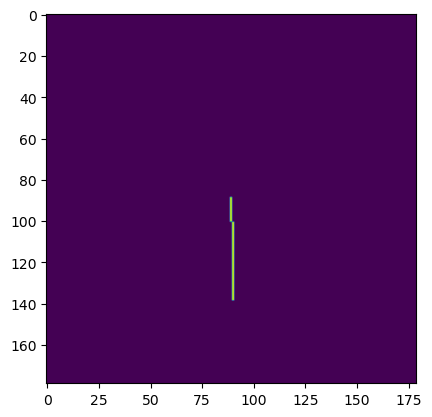

n_ep: 2 | n_bp: 0 | brnch_ls: (47,)


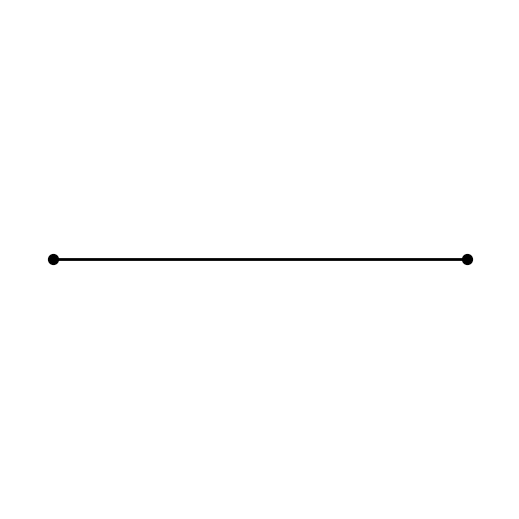

[0, 1]
47.0
0 0 -- 47.0


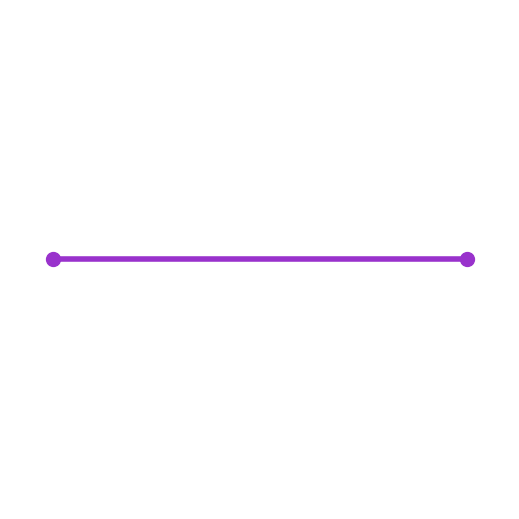

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_23_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


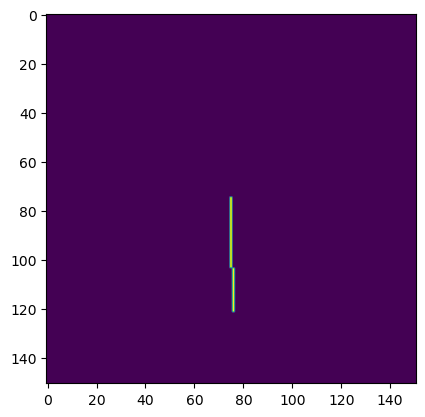

n_ep: 2 | n_bp: 0 | brnch_ls: (47,)


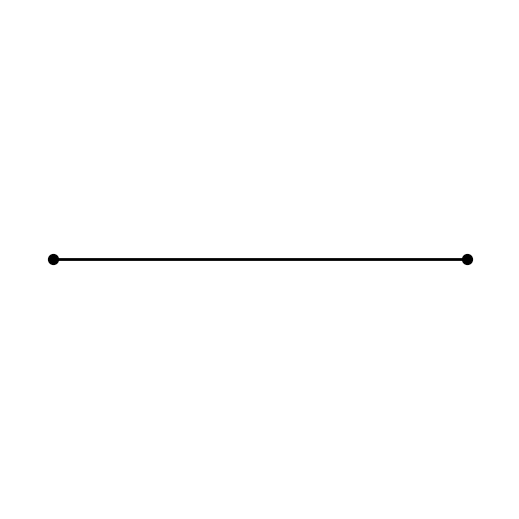

[0, 1]
47.0
0 0 -- 47.0


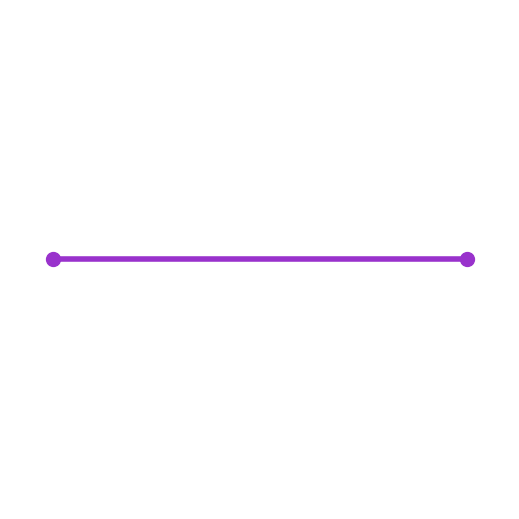

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_27_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


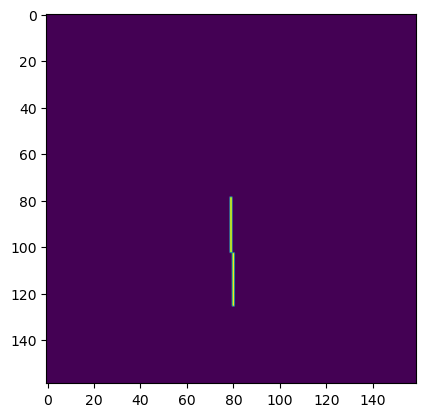

n_ep: 2 | n_bp: 0 | brnch_ls: (49,)


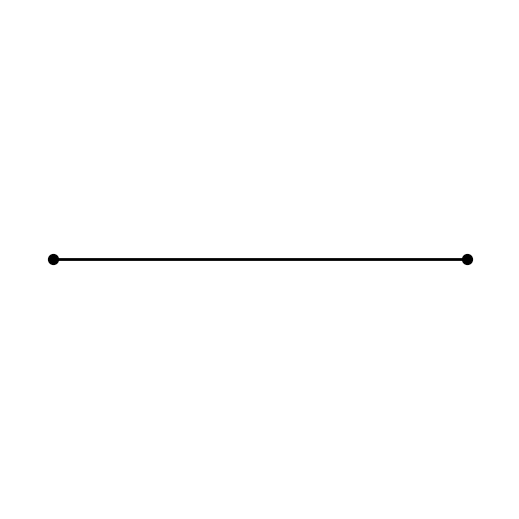

[0, 1]
49.0
0 0 -- 49.0


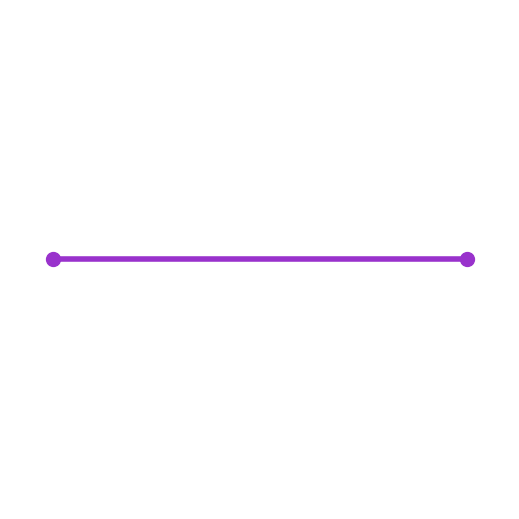

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_33_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


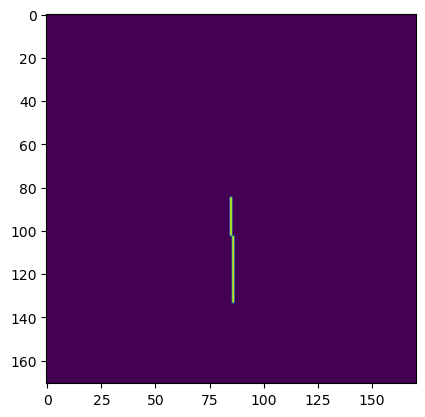

n_ep: 2 | n_bp: 0 | brnch_ls: (47,)


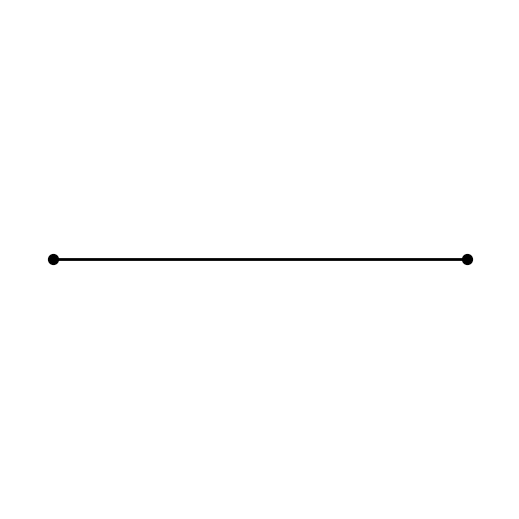

[0, 1]
47.0
0 0 -- 47.0


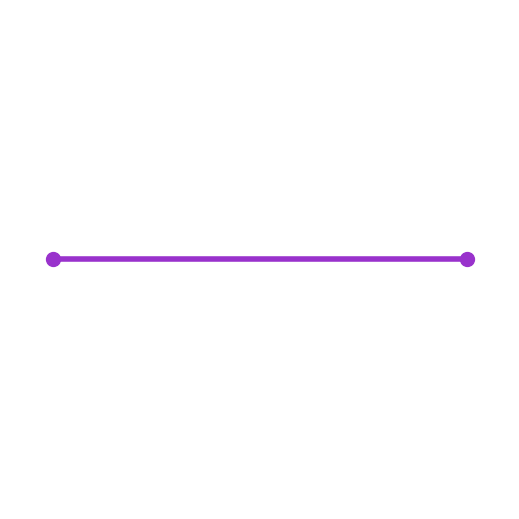

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_32_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


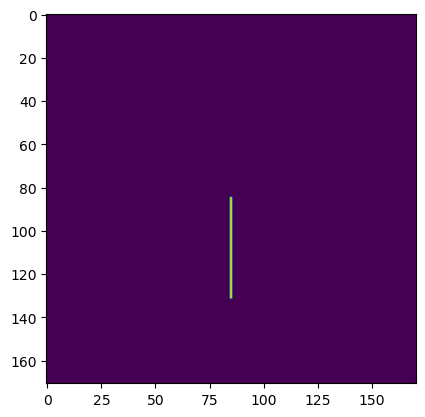

n_ep: 2 | n_bp: 0 | brnch_ls: (51,)


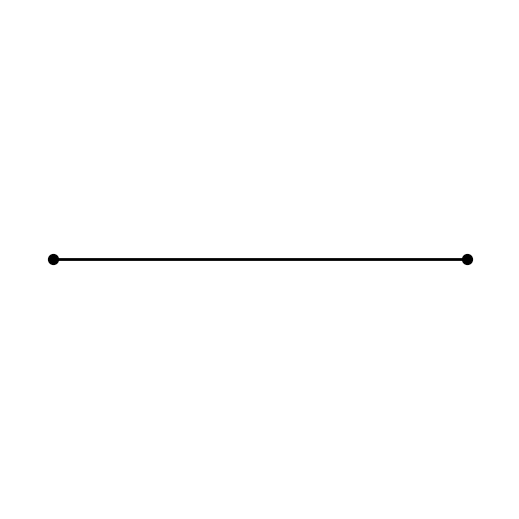

[0, 1]
51.0
0 0 -- 51.0


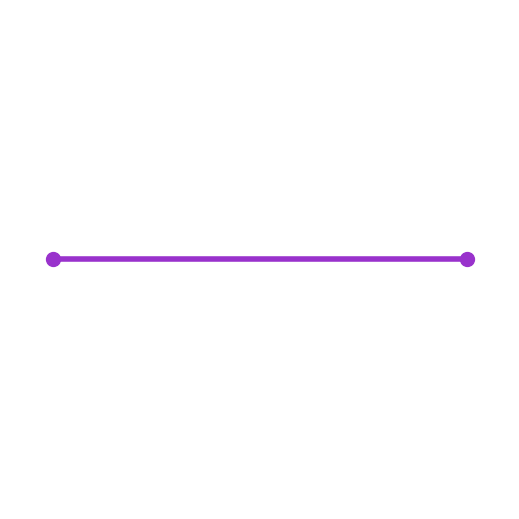

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_26_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


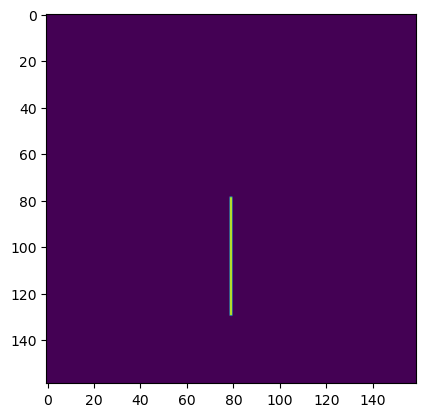

n_ep: 2 | n_bp: 0 | brnch_ls: (45,)


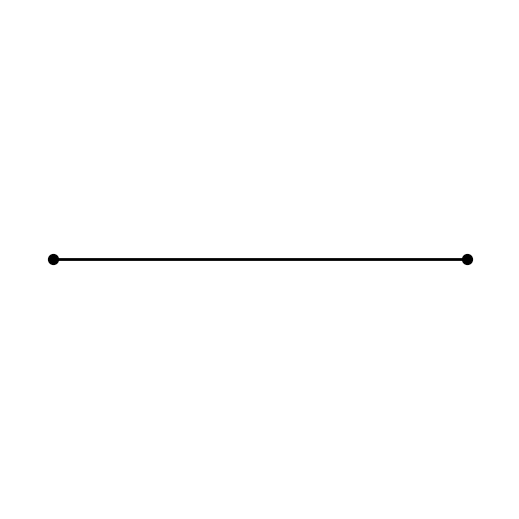

[0, 1]
45.0
0 0 -- 45.0


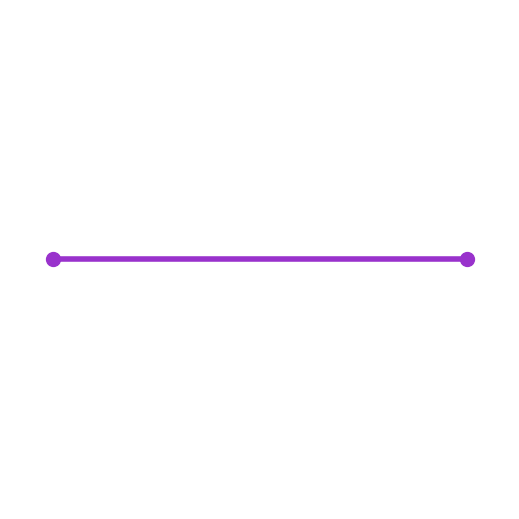

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_30_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


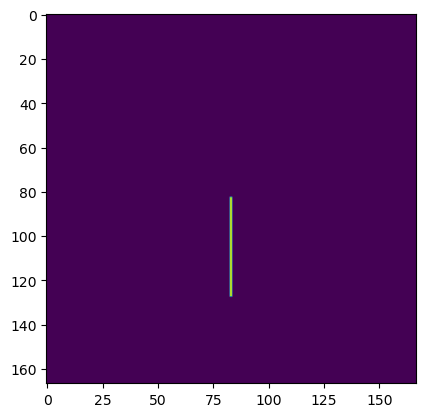

n_ep: 2 | n_bp: 0 | brnch_ls: (47,)


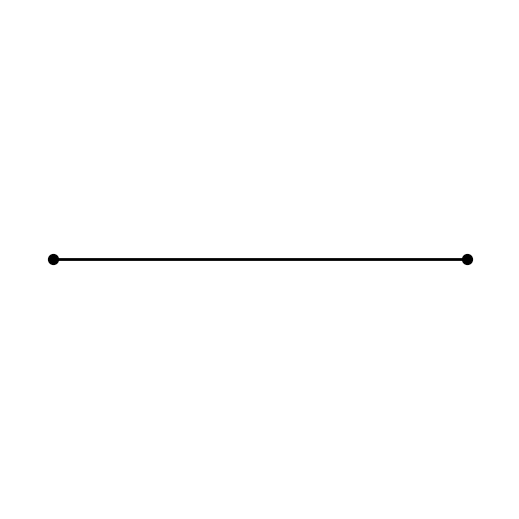

[0, 1]
47.0
0 0 -- 47.0


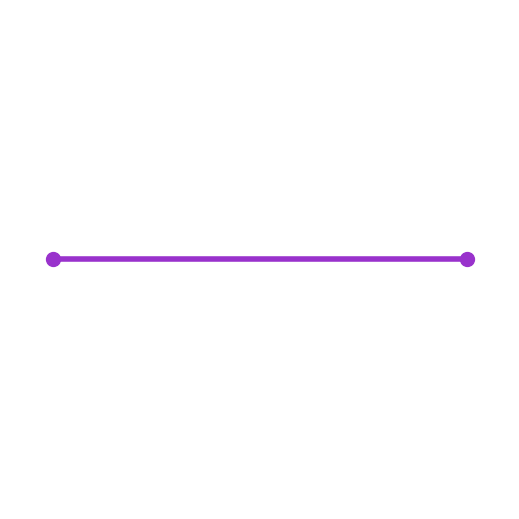

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_24_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


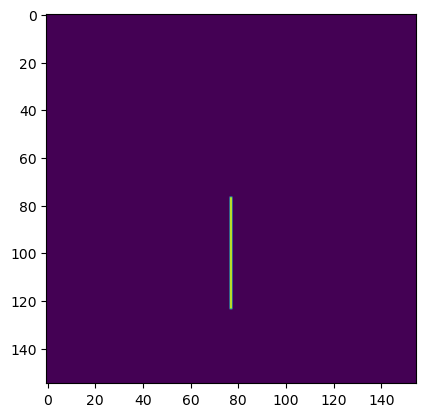

n_ep: 2 | n_bp: 0 | brnch_ls: (49,)


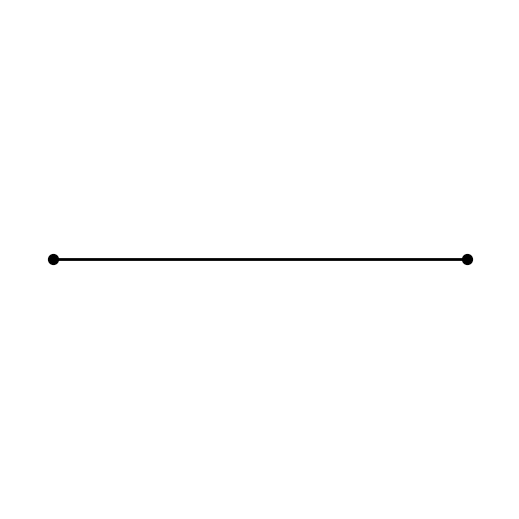

[0, 1]
49.0
0 0 -- 49.0


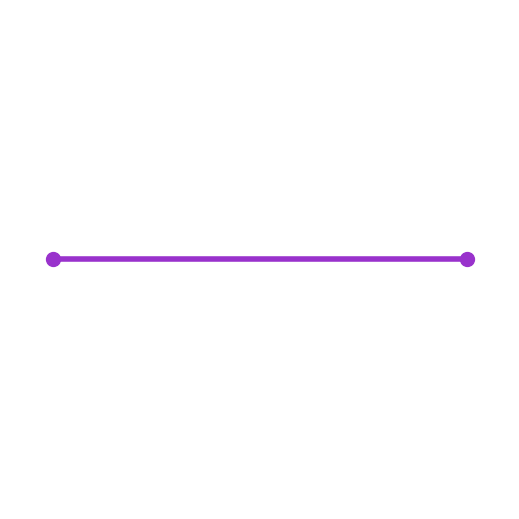

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_18_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


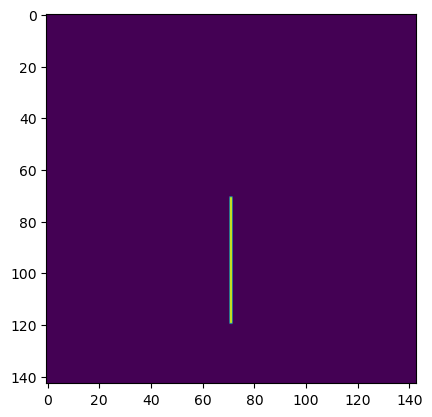

n_ep: 2 | n_bp: 0 | brnch_ls: (48,)


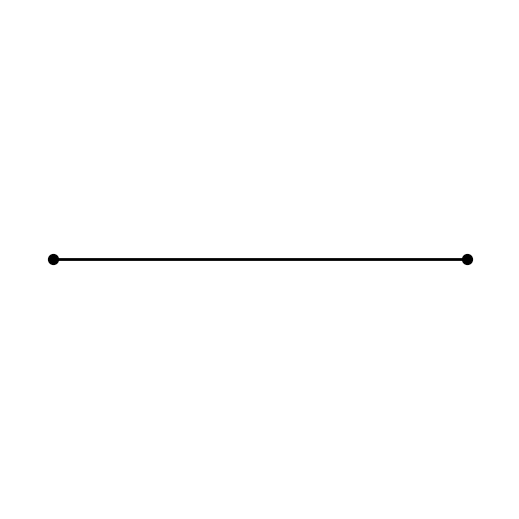

[0, 1]
48.0
0 0 -- 48.0


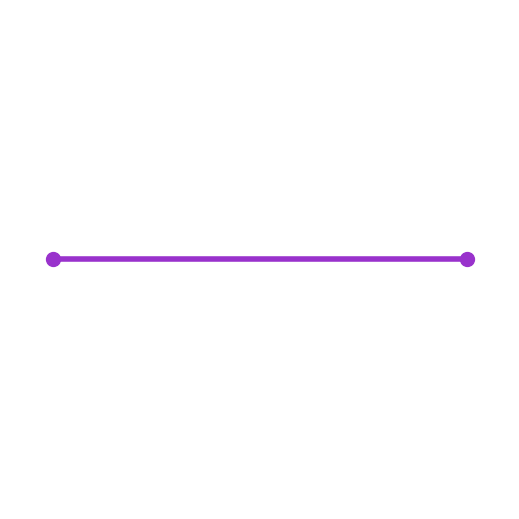

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_19_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


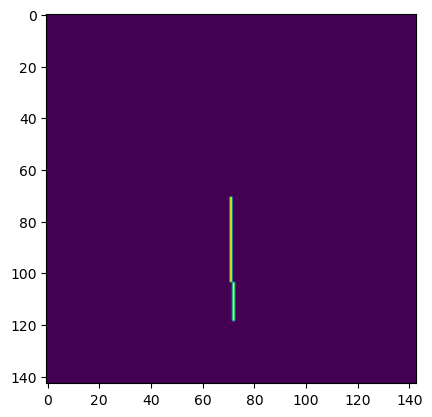

n_ep: 2 | n_bp: 0 | brnch_ls: (48,)


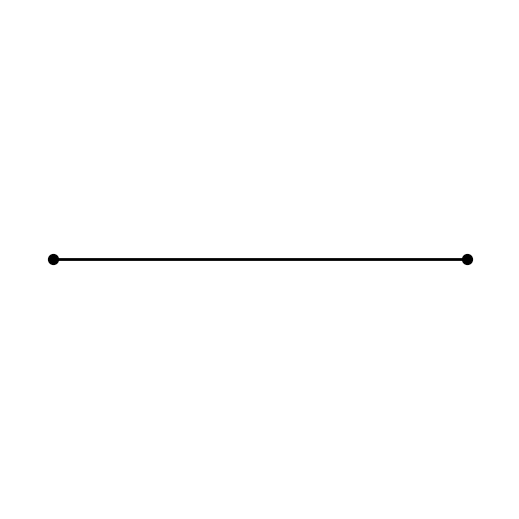

[0, 1]
48.0
0 0 -- 48.0


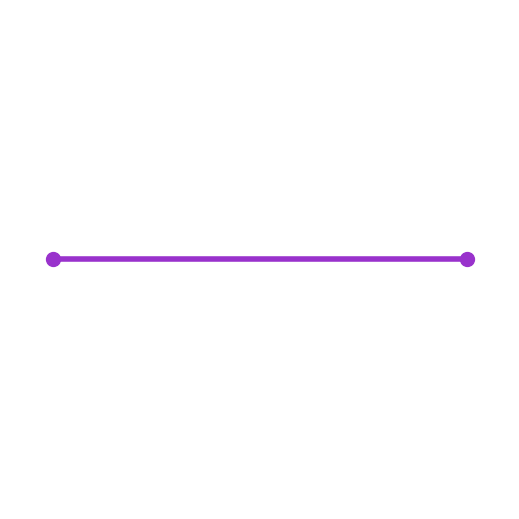

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_25_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


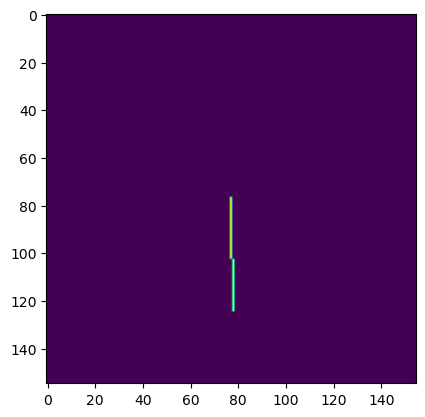

n_ep: 2 | n_bp: 0 | brnch_ls: (46,)


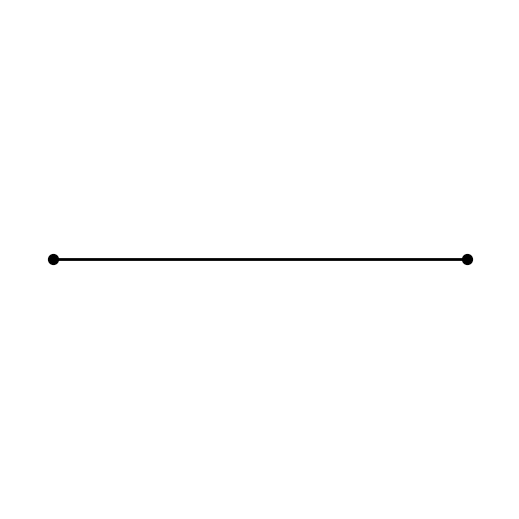

[0, 1]
46.0
0 0 -- 46.0


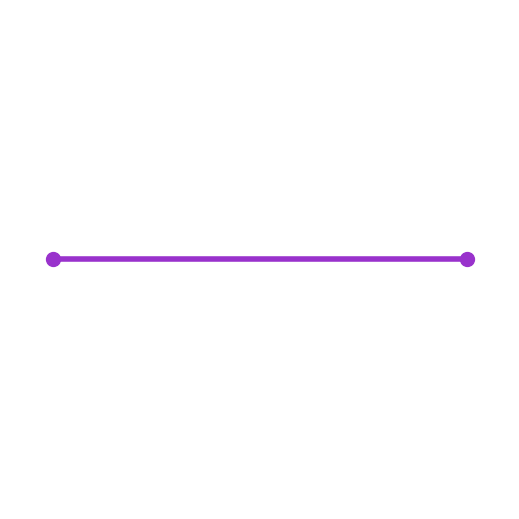

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_31_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


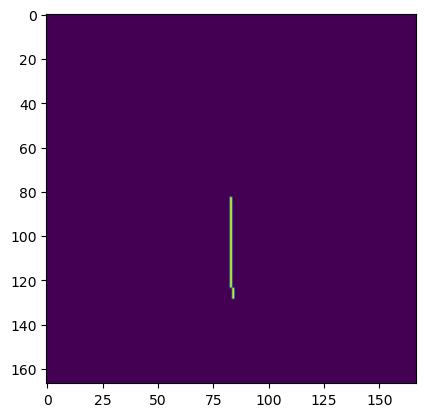

n_ep: 2 | n_bp: 0 | brnch_ls: (46,)


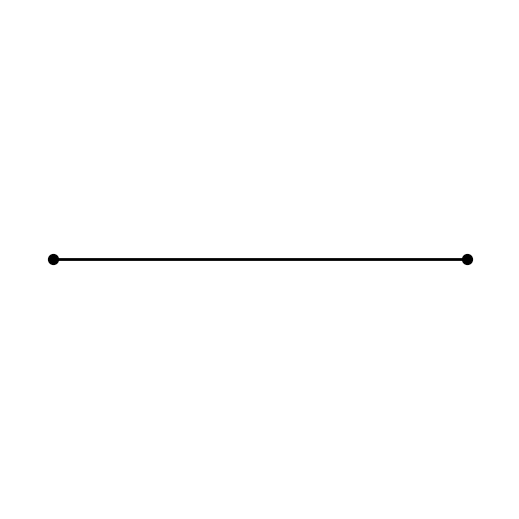

[0, 1]
46.0
0 0 -- 46.0


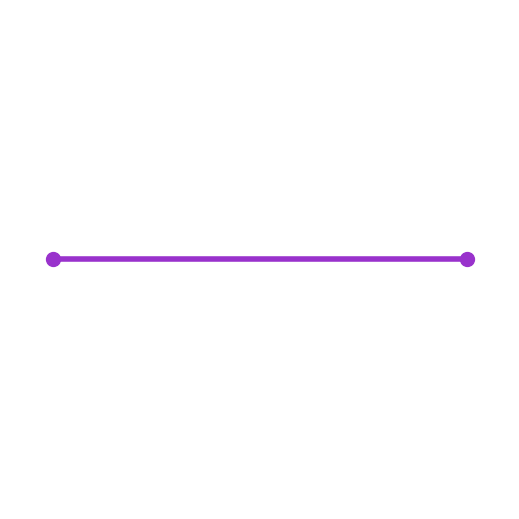

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_28_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


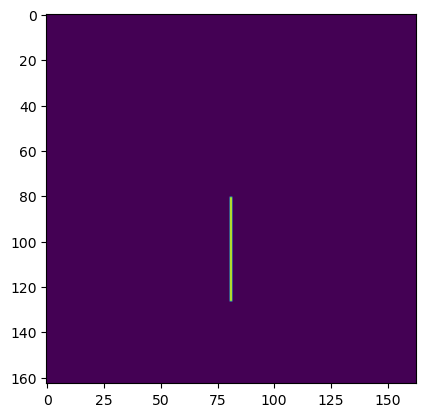

n_ep: 2 | n_bp: 0 | brnch_ls: (49,)


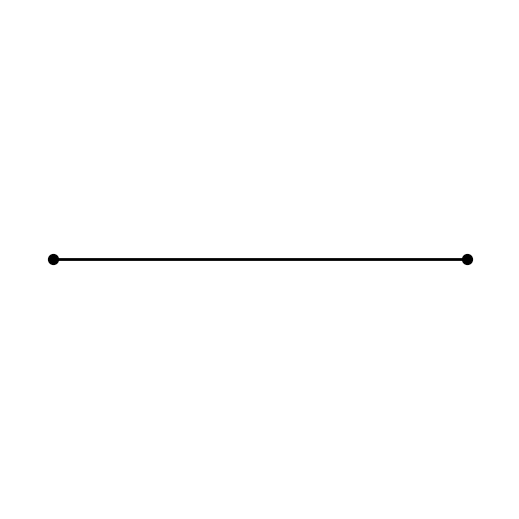

[0, 1]
49.0
0 0 -- 49.0


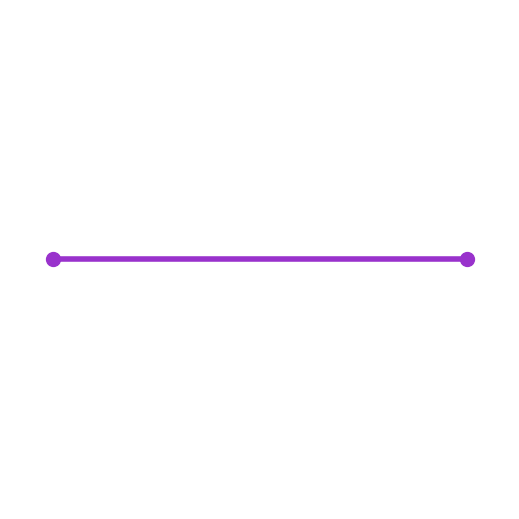

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_14_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


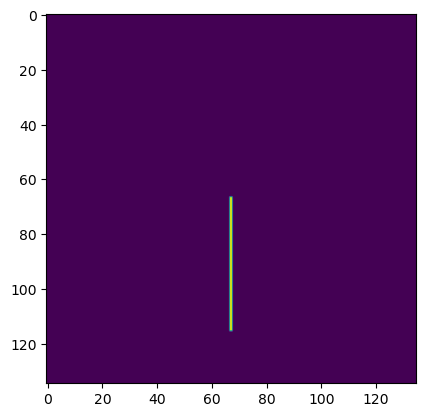

n_ep: 2 | n_bp: 0 | brnch_ls: (47,)


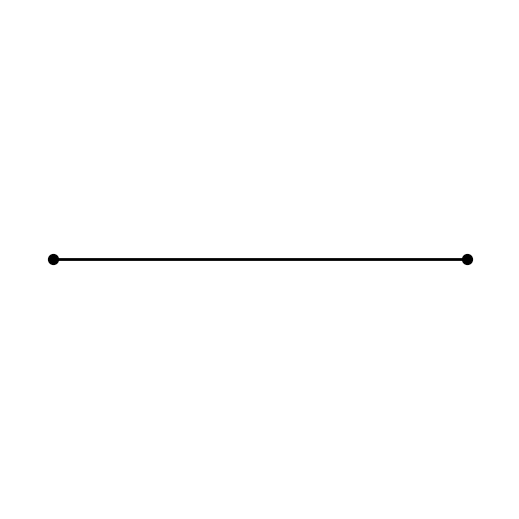

[0, 1]
47.0
0 0 -- 47.0


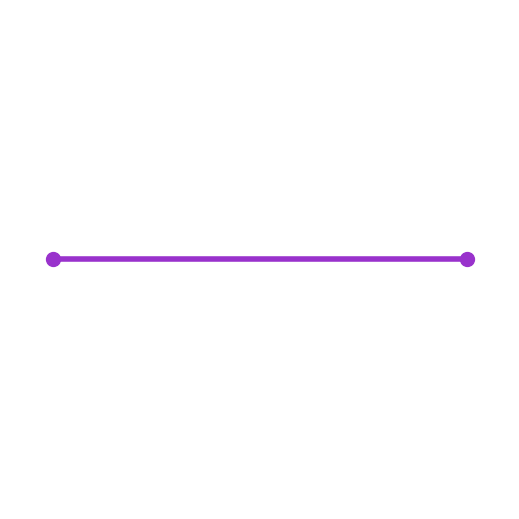

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_15_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


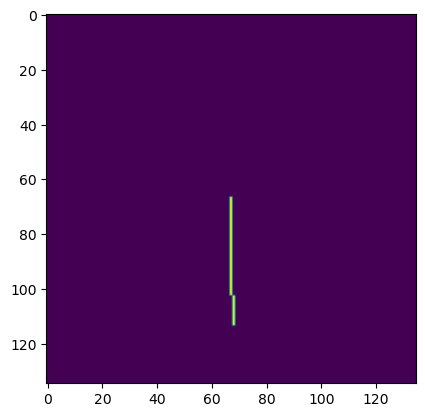

n_ep: 2 | n_bp: 0 | brnch_ls: (49,)


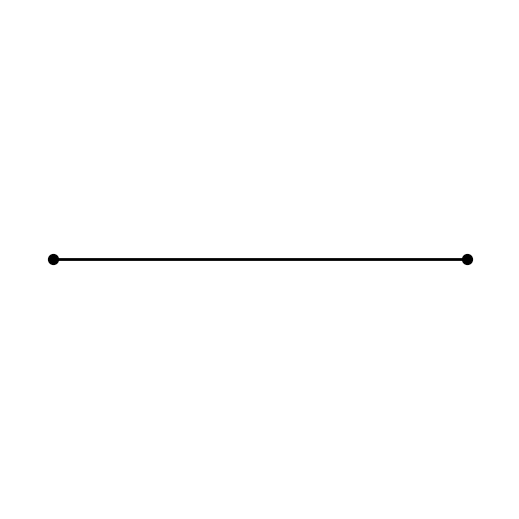

[0, 1]
49.0
0 0 -- 49.0


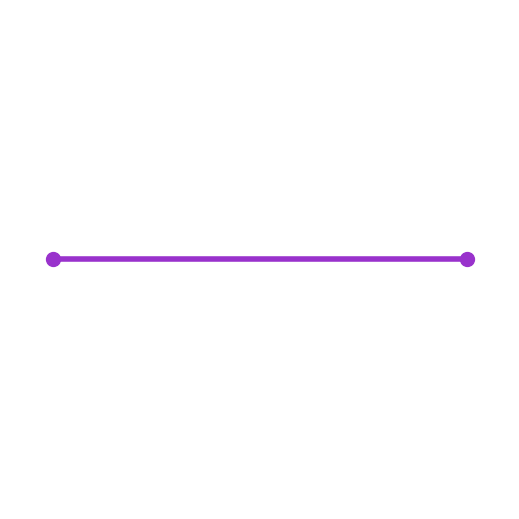

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_29_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


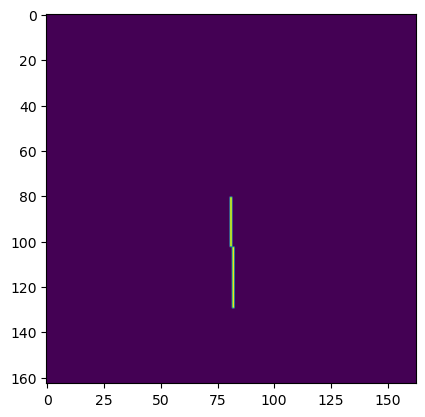

n_ep: 2 | n_bp: 0 | brnch_ls: (49,)


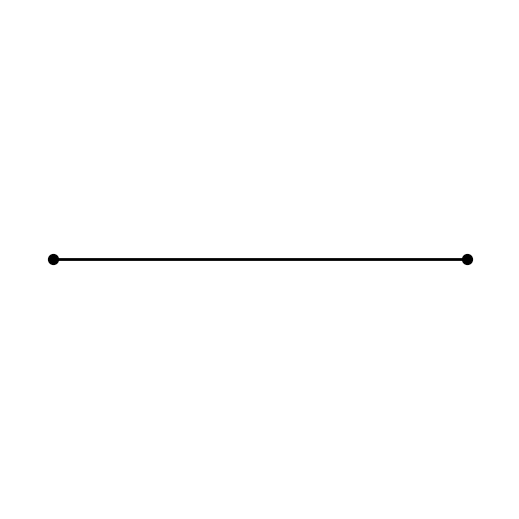

[0, 1]
49.0
0 0 -- 49.0


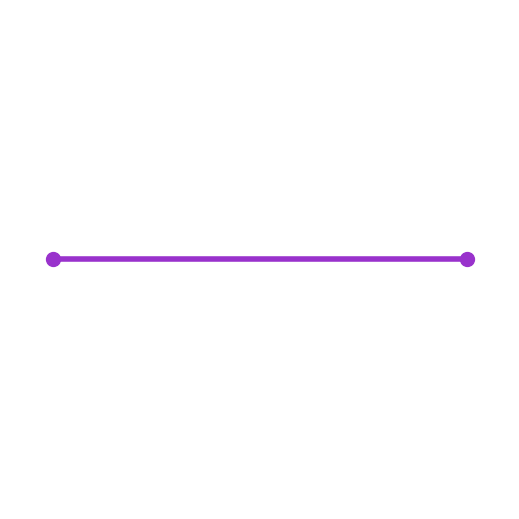

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_17_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


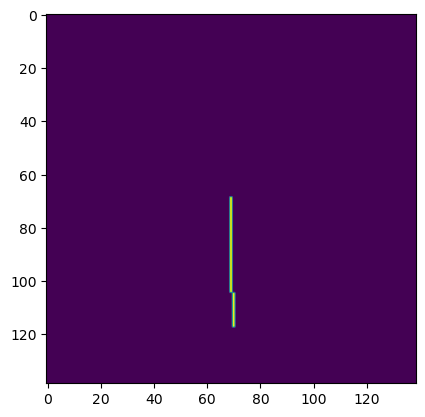

n_ep: 2 | n_bp: 0 | brnch_ls: (48,)


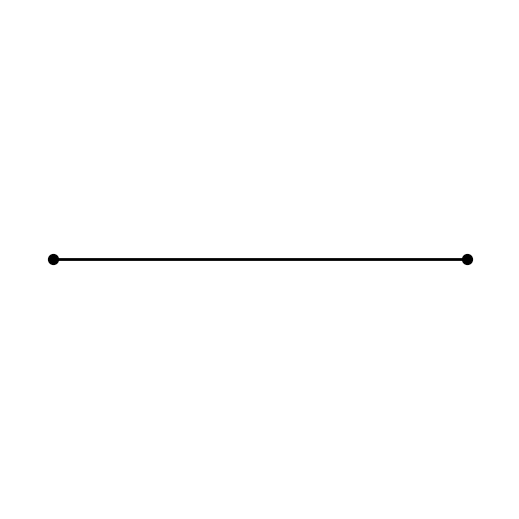

[0, 1]
48.0
0 0 -- 48.0


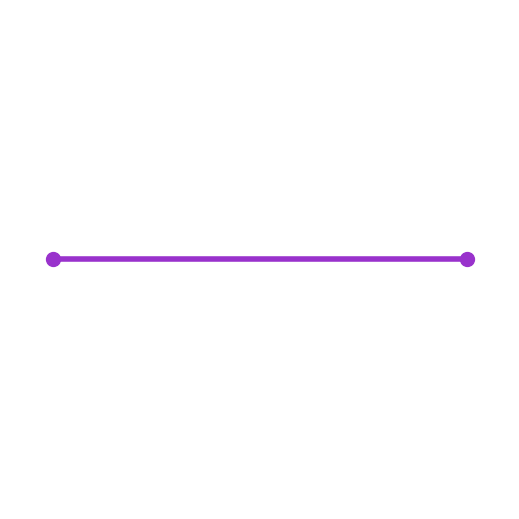

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_16_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


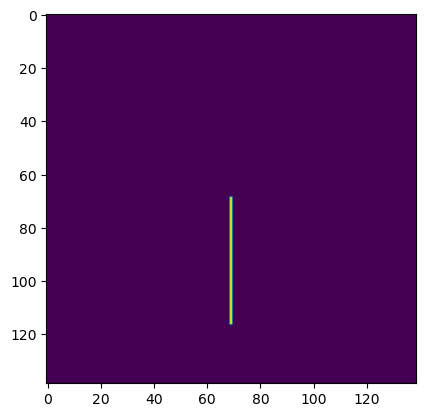

n_ep: 2 | n_bp: 0 | brnch_ls: (47,)


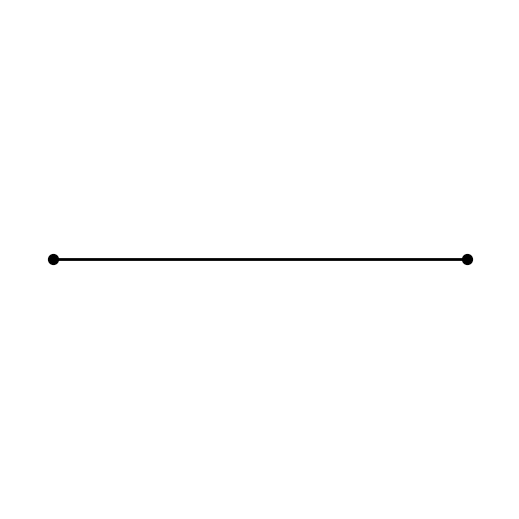

[0, 1]
47.0
0 0 -- 47.0


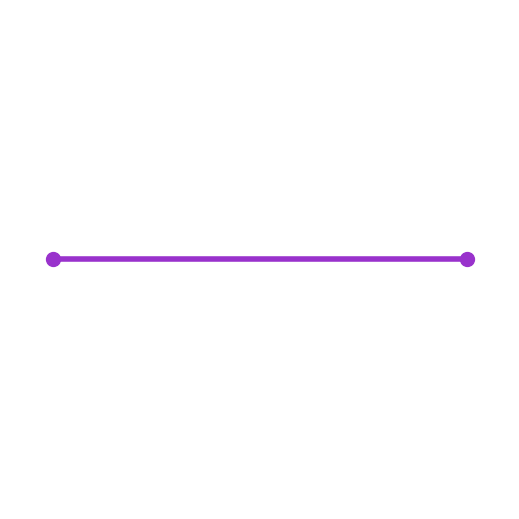

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_12_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


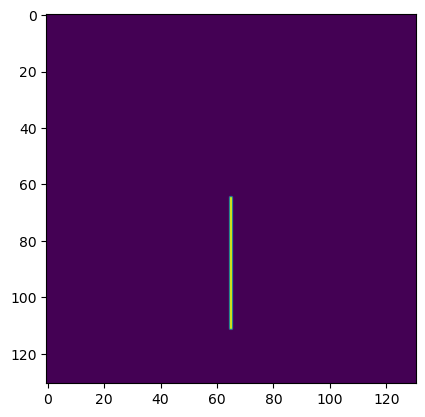

n_ep: 2 | n_bp: 0 | brnch_ls: (50,)


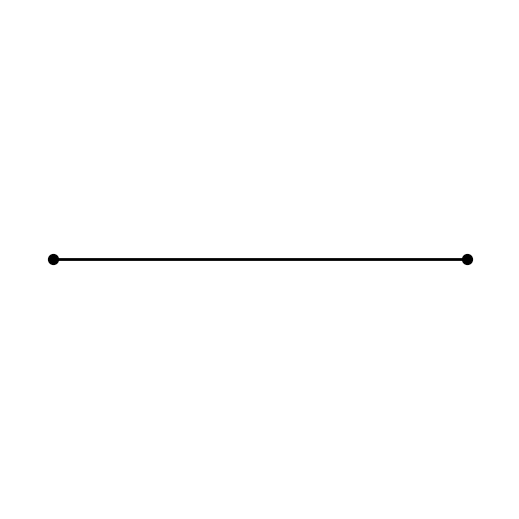

[0, 1]
50.0
0 0 -- 50.0


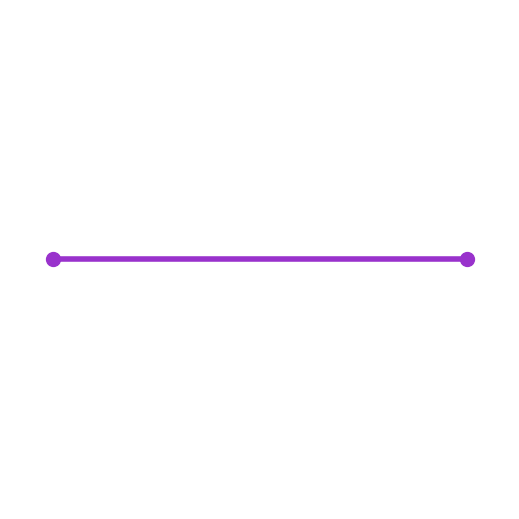

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_13_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


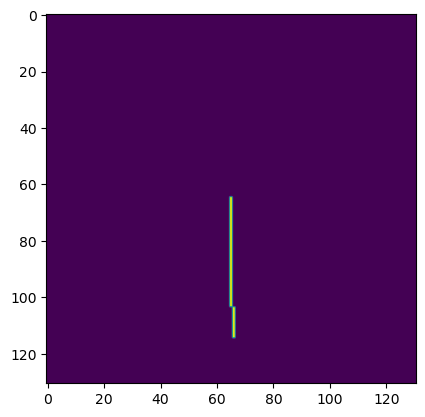

n_ep: 2 | n_bp: 0 | brnch_ls: (51,)


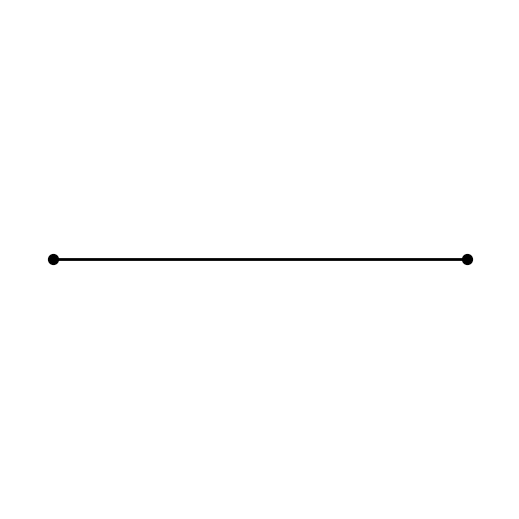

[0, 1]
51.0
0 0 -- 51.0


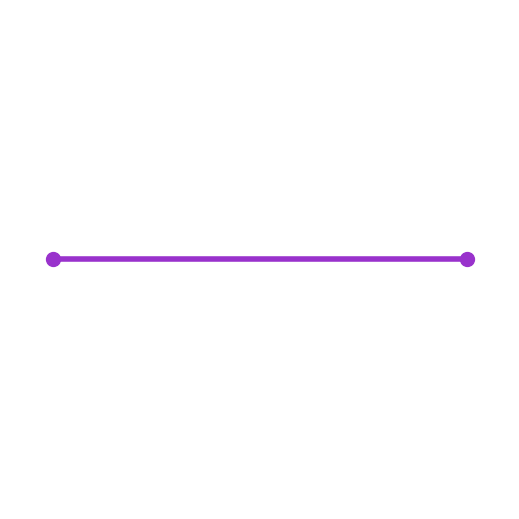

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_11_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


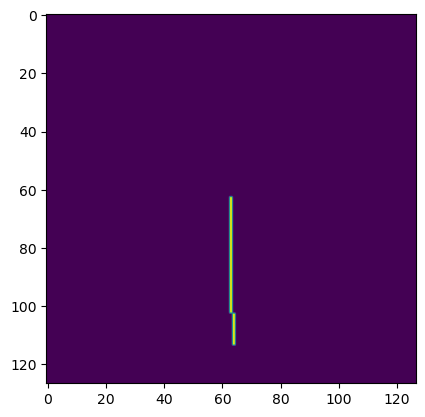

n_ep: 2 | n_bp: 0 | brnch_ls: (47,)


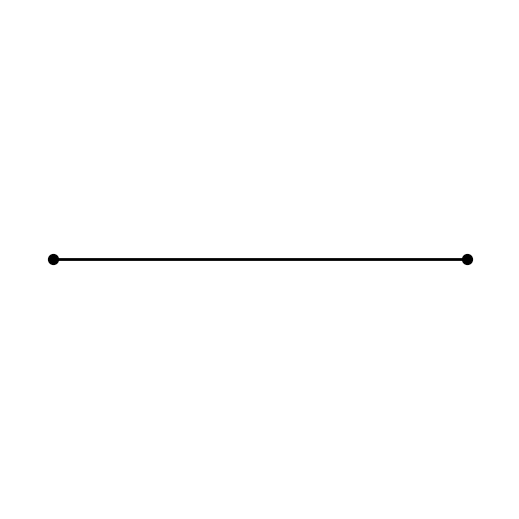

[0, 1]
47.0
0 0 -- 47.0


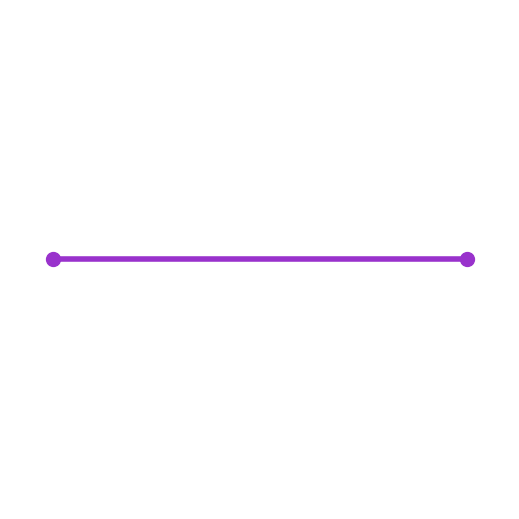

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_39_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


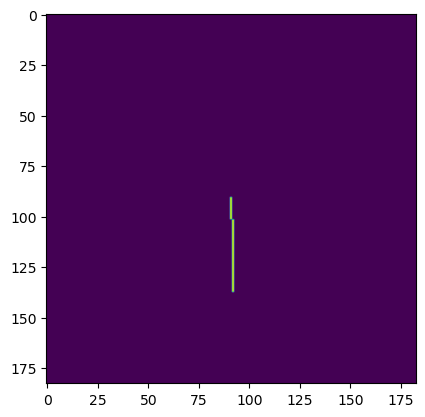

n_ep: 2 | n_bp: 0 | brnch_ls: (44,)


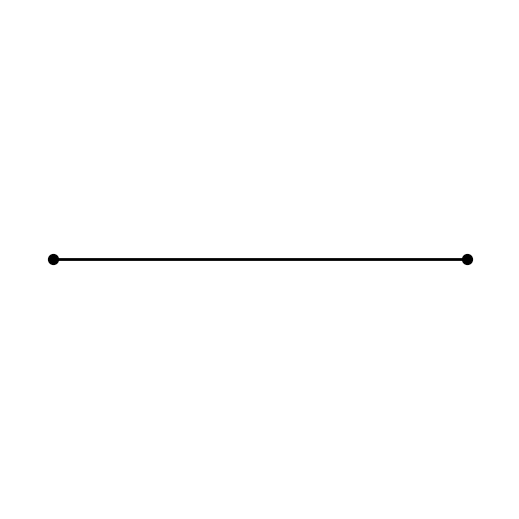

[0, 1]
44.0
0 0 -- 44.0


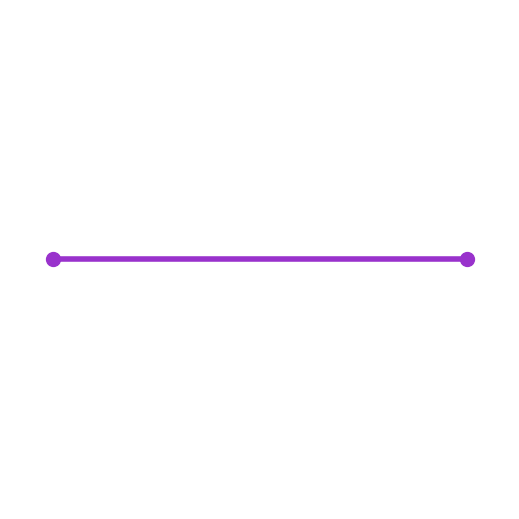

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_38_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


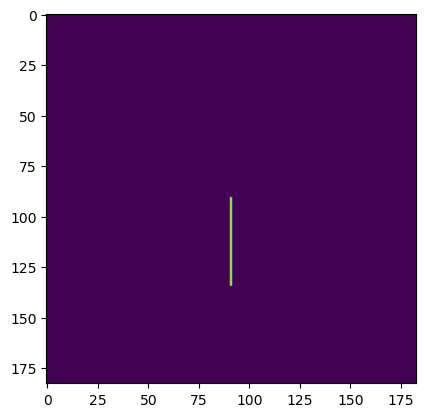

n_ep: 2 | n_bp: 0 | brnch_ls: (50,)


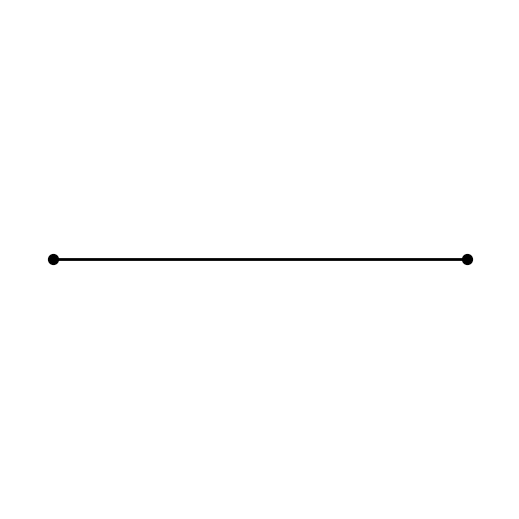

[0, 1]
50.0
0 0 -- 50.0


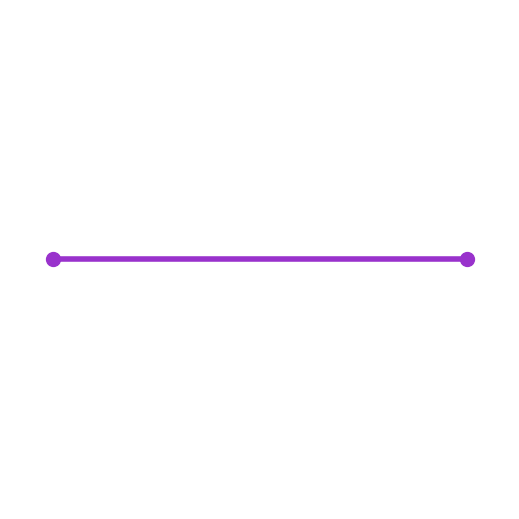

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_10_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


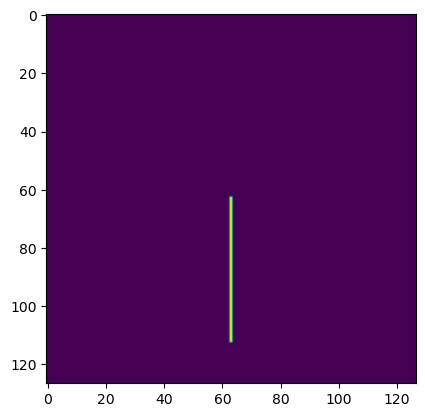

n_ep: 2 | n_bp: 0 | brnch_ls: (52,)


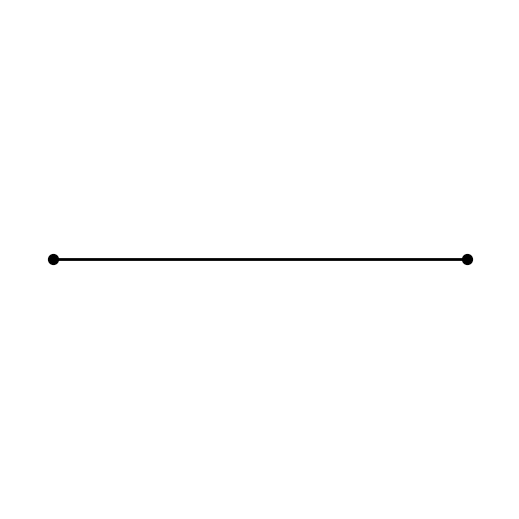

[0, 1]
52.0
0 0 -- 52.0


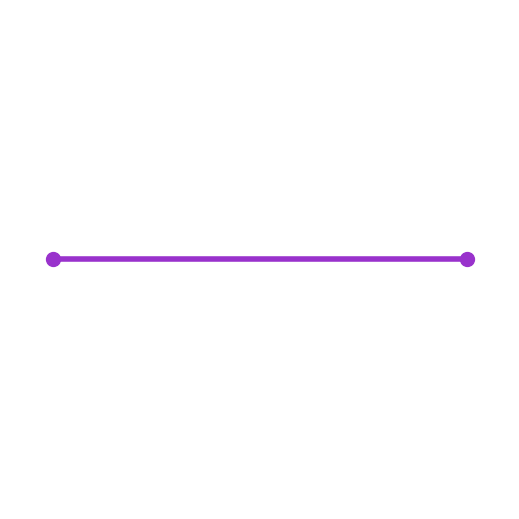

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_7_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


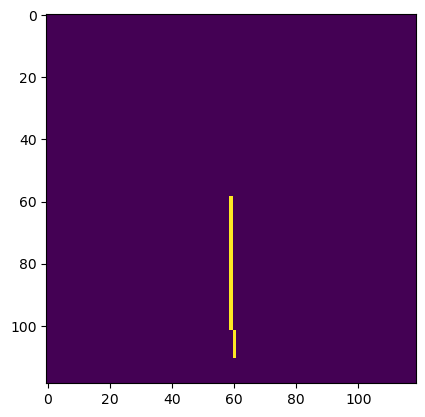

n_ep: 2 | n_bp: 0 | brnch_ls: (49,)


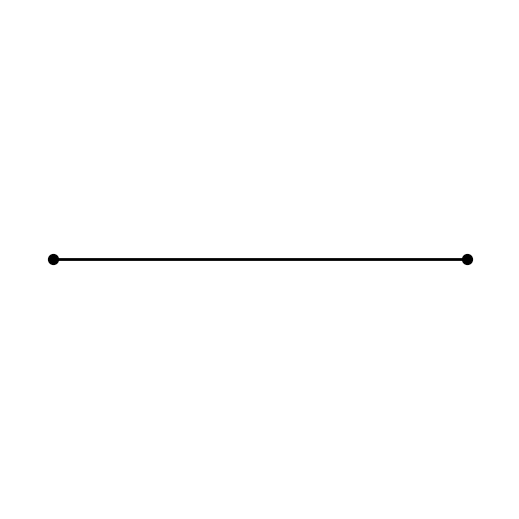

[0, 1]
49.0
0 0 -- 49.0


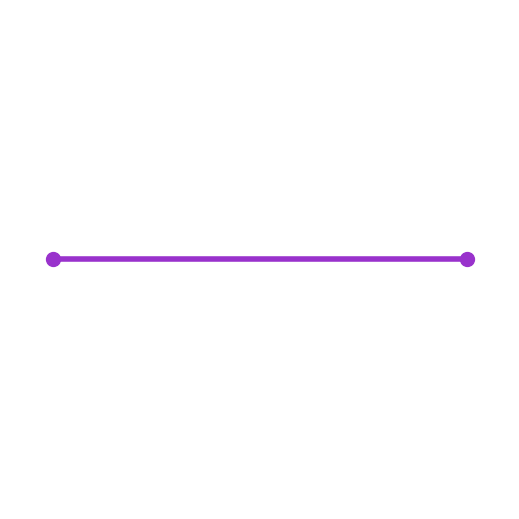

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_6_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


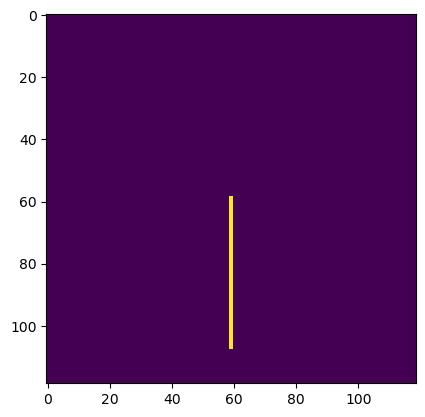

n_ep: 2 | n_bp: 0 | brnch_ls: (45,)


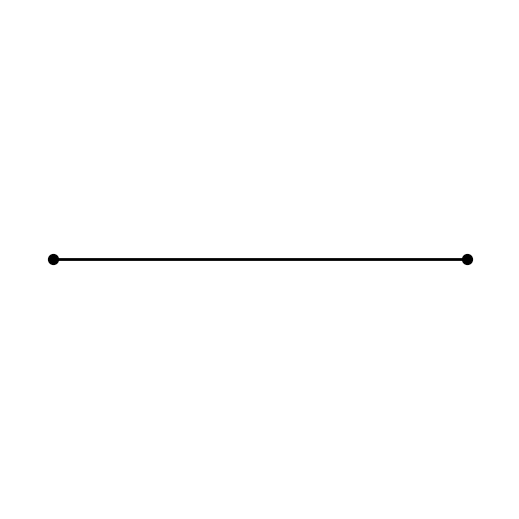

[0, 1]
45.0
0 0 -- 45.0


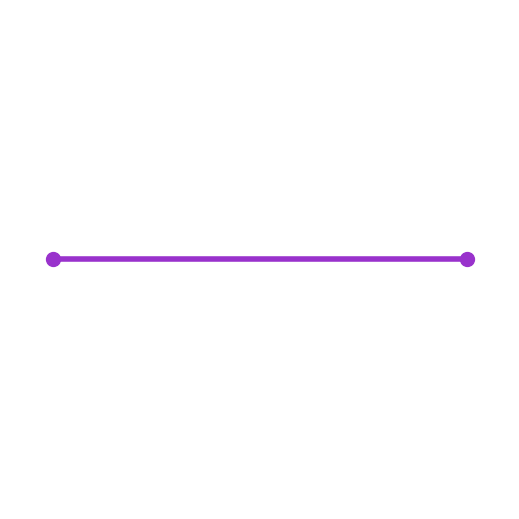

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_48_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


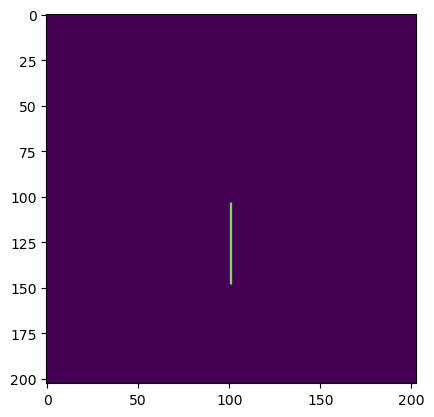

n_ep: 2 | n_bp: 0 | brnch_ls: (49,)


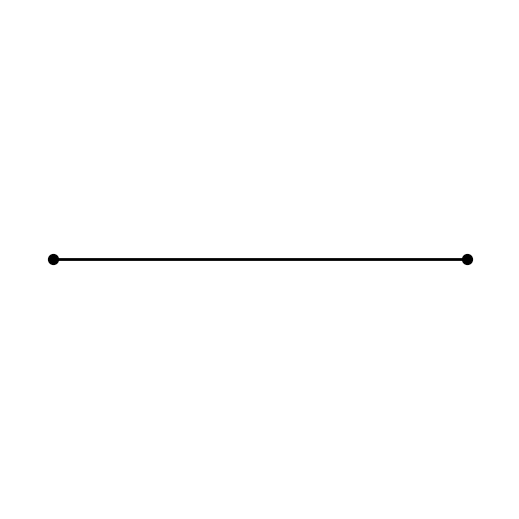

[0, 1]
49.0
0 0 -- 49.0


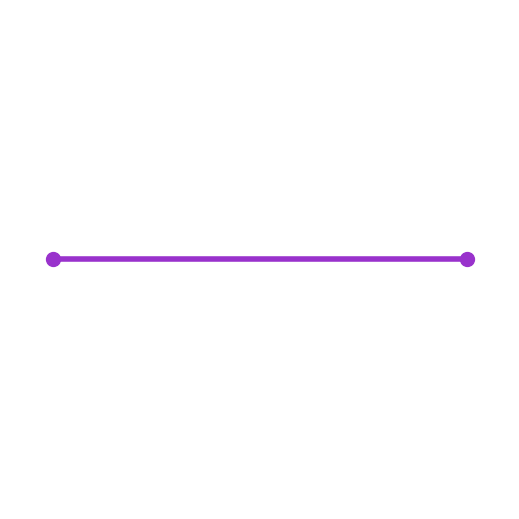

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_4_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


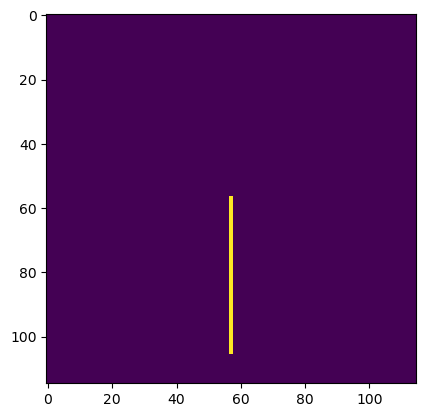

n_ep: 2 | n_bp: 0 | brnch_ls: (51,)


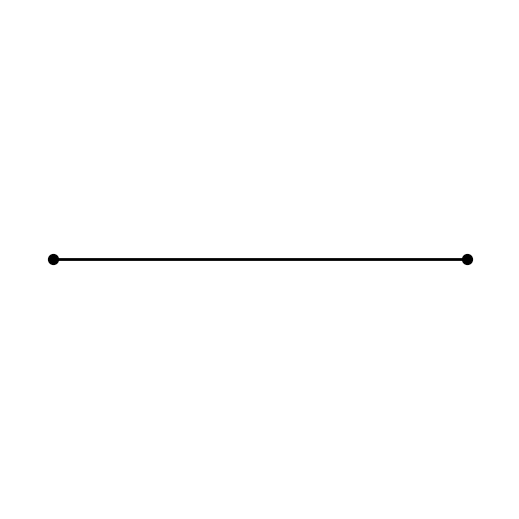

[0, 1]
51.0
0 0 -- 51.0


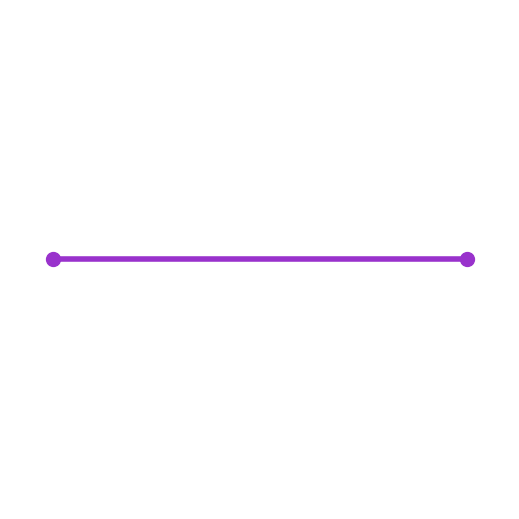

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_5_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


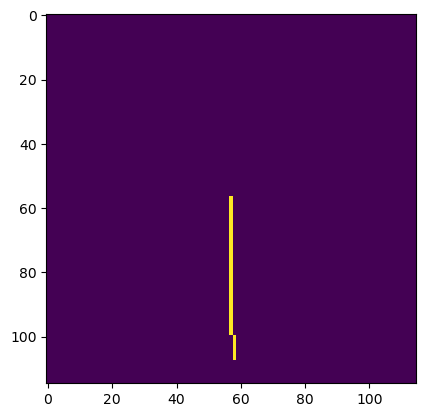

n_ep: 2 | n_bp: 0 | brnch_ls: (53,)


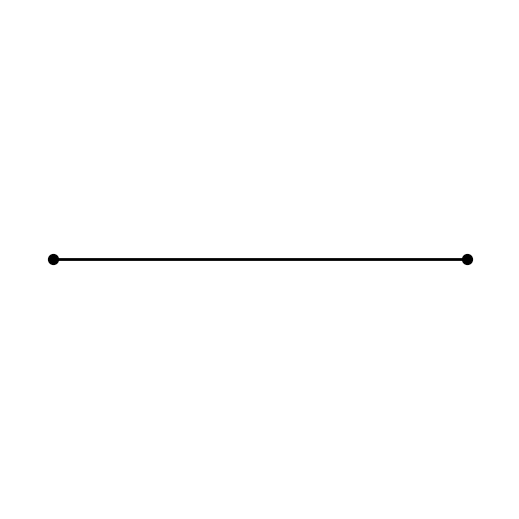

[0, 1]
53.0
0 0 -- 53.0


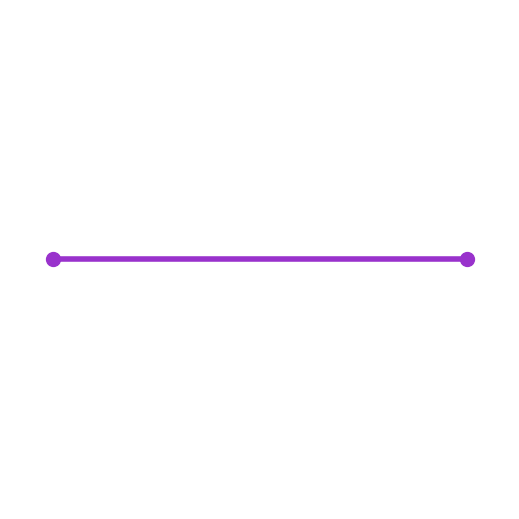

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_1_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


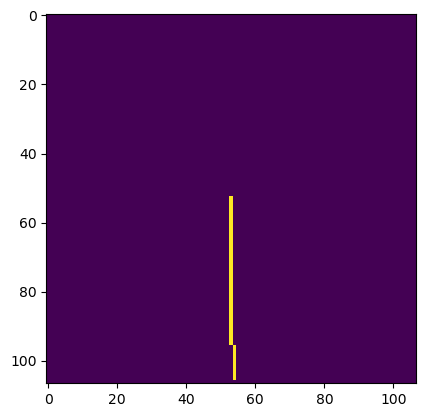

n_ep: 2 | n_bp: 0 | brnch_ls: (51,)


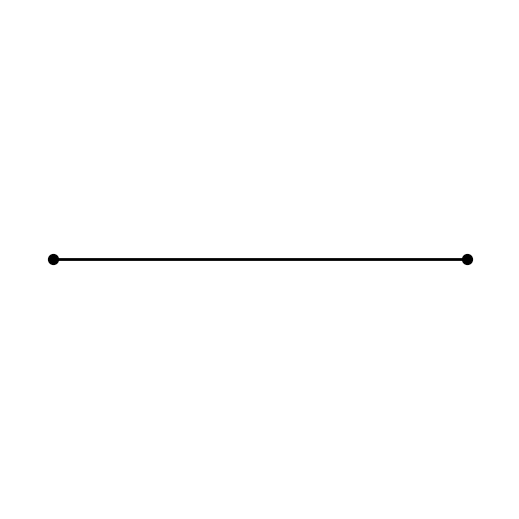

[0, 1]
51.0
0 0 -- 51.0


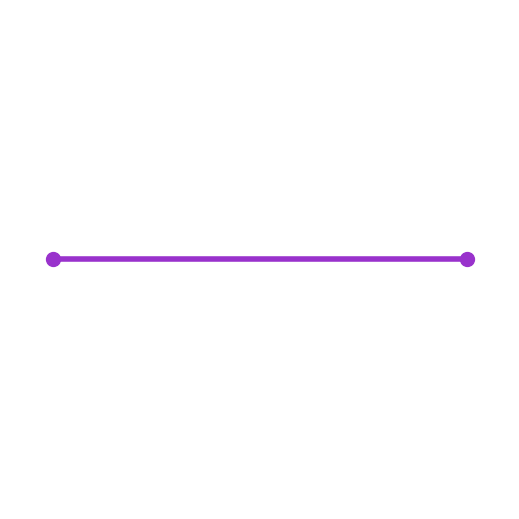

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_2_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


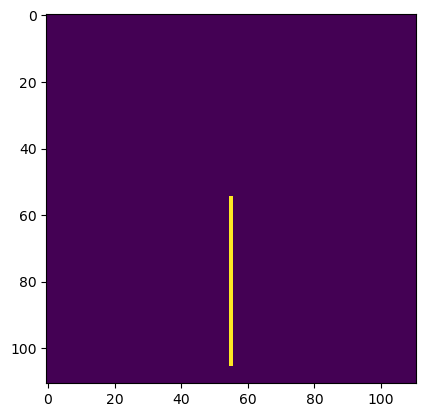

n_ep: 2 | n_bp: 0 | brnch_ls: (51,)


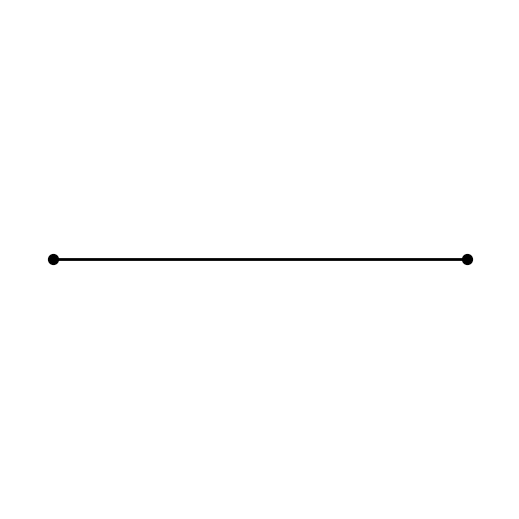

[0, 1]
51.0
0 0 -- 51.0


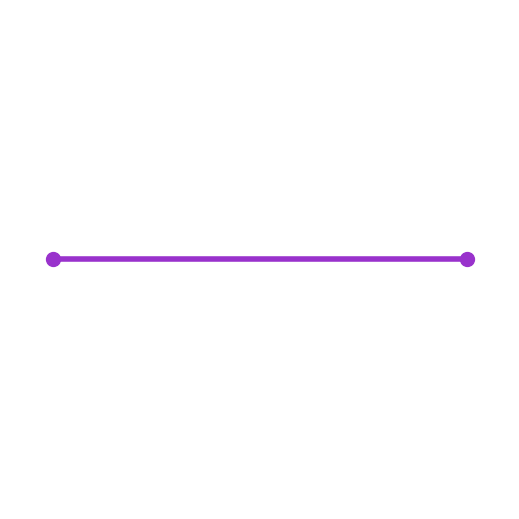

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_26953/3001294302.py:98: UserWarning: /Users/ryan/Desktop/toska_figs/reference_shapes/budding_yeast/r1_50_r2_3_spine.tif is a low contrast image
  imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))


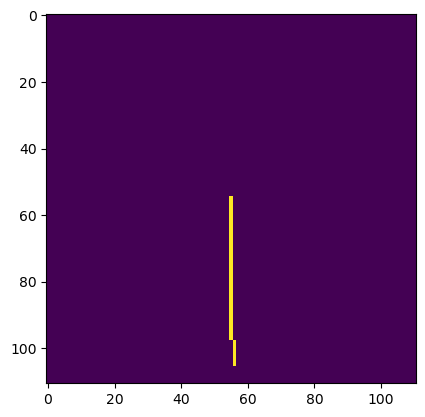

In [13]:
## generate networks

for i in range(n_samples):
    i_parse = parsings[i]
    dims = len(skels[i].shape)
    skel_coords, e_pts, b_pts, brnch, brnch_ids, brnch_ls = i_parse
    m_branches = np.amax(brnch_ids)
    n_ep = len(e_pts)
    bp_img, n_bp = relabel_branching_pts(b_pts, brnch.shape, brnch.dtype)
    np.save(os.path.join(fpath, names[i] + '_nep_nbp_nbrnch'), np.asarray((n_ep, n_bp, m_branches)))
    
    print('n_ep:', n_ep, '| n_bp:', n_bp, '| brnch_ls:', brnch_ls)
    
    if ((n_bp == 0) & (m_branches == 1) & (n_ep == 2)):
        ep_adj = np.ones((2,1)) # ((n_ep, m_branches))
        bp_adj = 0
        nodes, weighted_edges, G = skeleton_network_no_branching(ep_adj, brnch_ls)
        pos = nx.kamada_kawai_layout(G)
        labels = nx.get_edge_attributes(G,'weight')
        
        nx.readwrite.write_weighted_edgelist(G, os.path.join(fpath, names[i] + '_G'))
        np.save(os.path.join(fpath, names[i] + '_nodes'), nodes)
        np.save(os.path.join(fpath, names[i] + '_weighted_edges'), np.asarray(weighted_edges, dtype = int))
        
        plt.figure(figsize = (5,5))
        nx.draw(G, pos, with_labels = False, node_size = 50, node_color = 'k', width = 2, font_size = 24)
        plt.axis('equal')
        plt.savefig(os.path.join(fpath, names[i] + '_network.svg'), dpi = 300)
        plt.show()
                                             
    
    elif ((n_bp > 0) & (n_ep >= 1)):
        ep_adj = end_pt_adjacency_matrix(e_pts, brnch, m_branches)
        bp_adj = branching_adjacency_matrix(bp_img, n_bp, brnch, m_branches)
        nodes, weighted_edges, G = skeleton_network(bp_adj, ep_adj, brnch_ls)
        pos = nx.kamada_kawai_layout(G)
        labels = nx.get_edge_attributes(G,'weight')
        
        nx.readwrite.write_weighted_edgelist(G, os.path.join(fpath, names[i] + '_G'))
        np.save(os.path.join(fpath, names[i] + '_nodes'), nodes)
        np.save(os.path.join(fpath, names[i] + '_weighted_edges'), np.asarray(weighted_edges, dtype = int))
        
        plt.figure(figsize = (5,5))
        nx.draw(G, pos, with_labels = False, node_size = 50, node_color = 'k', width = 2, font_size = 24)
        plt.axis('equal')
        plt.savefig(os.path.join(fpath, names[i] + '_network.svg'), dpi = 300)
        plt.show()
    
    elif ((n_bp > 0) & (n_ep == 0)):
        ep_adj = 0
        bp_adj = branching_adjacency_matrix(bp_img, n_bp, brnch, m_branches)
        nodes, weighted_edges, G = skeleton_network_no_endpoints(bp_adj, brnch_ls)
        pos = nx.kamada_kawai_layout(G)
        labels = nx.get_edge_attributes(G,'weight')
        
        nx.readwrite.write_weighted_edgelist(G, os.path.join(fpath, names[i] + '_G'))
        np.save(os.path.join(fpath, names[i] + '_nodes'), nodes)
        np.save(os.path.join(fpath, names[i] + '_weighted_edges'), np.asarray(weighted_edges, dtype = int))
        
        plt.figure(figsize = (5,5))
        nx.draw(G, pos, with_labels = False, node_size = 50, node_color = 'k', width = 2, font_size = 24)
        plt.axis('equal')
        plt.savefig(os.path.join(fpath, names[i] + '_network.svg'), dpi = 300)
        plt.show()
    
    else:
        print('unrepresented graph type')
        
    if n_ep > 1:
        spine_path, spine_length = skeleton_spine_search(nodes, G)
        plt.figure(figsize = (5,5))
        nx.draw(G,pos, 
                with_labels = False, 
                node_size = 50, 
                node_color = 'k', 
                width = 2, 
                font_size = 24)
        
        nx.draw_networkx_nodes(G, pos, 
                               nodelist = spine_path, 
                               node_color='darkorchid', 
                               node_size = 100)
        
        nx.draw_networkx_edges(G, pos, 
                               edgelist = list(zip(spine_path, 
                                                   spine_path[1:])), 
                               edge_color='darkorchid', width=4)
        
        plt.axis('equal')
        plt.savefig(os.path.join(fpath, names[i] + '_network_with_spine.svg'), dpi = 300)
        plt.show()
        
        
        spine_edges = find_spine_edges(spine_path)
        img_spine_edges = map_spine_edges(spine_edges, nodes, brnch_ls, brnch_ids)
        spine_img = create_spine_img(brnch, img_spine_edges)
        spine_img[spine_img > 0] = 1
        imsave(os.path.join(fpath, names[i] + '_spine.tif'), spine_img.astype(np.uint8))
        
        if dims >= 3:
            plt.imshow(spine_img.max(axis = 0))
            plt.show()
        else:
            plt.imshow(spine_img)
            plt.show()
        
    else:
        spine_path, spine_length = (0,0)
        print('no spine, sum brnch_ls = ', np.sum(brnch_ls))
    
    np.save(os.path.join(fpath, names[i] + '_spine_path'), spine_path)
    np.save(os.path.join(fpath, names[i] + '_spine_len'), spine_length)
    